# **Data Analysis Cycle**

[![Open in Colab](http://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thekimk/All-About-Time-Series-Analysis/blob/main/Practice2-7_DataAnalysis_TimeSeries_RealityMulticollinearity_KK.ipynb)

<center><img src='Image/Advanced/DataAnalysis_CycleTS0.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle1.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_CycleTS1.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_CycleTS3.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_CycleTS4.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_CycleTS2.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_CycleTS5.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle4.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle5.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle6.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle7.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle8.png' width='800'></center>
<center><img src='Image/Advanced/DataAnalysis_Cycle9.png' width='800'></center>

# **Import Library:** 분석에 사용할 모듈 설치

In [1]:
!pip install --upgrade pip
!python -m pip install --user --upgrade pip

In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm

# Modeling algorithms
# General
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics
# for regression
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

## 분석가 정의 함수

In [3]:
# 시계열 변수추출
## 날짜인식 및 빈도 설정만
def non_feature_engineering(df):
    df_nfe = df.copy()
    if 'datetime' in df_nfe.columns:
        df_nfe['datetime'] = pd.to_datetime(df_nfe['datetime'])
        df_nfe['DateTime'] = pd.to_datetime(df_nfe['datetime'])
    if df_nfe.index.dtype == 'int64':
        df_nfe.set_index('DateTime', inplace=True)
    df_nfe = df_nfe.asfreq('H', method='ffill')

    return df_nfe


## 날짜인식 및 빈도 설정을 포함한 모든 전처리
def feature_engineering(df):
    df_fe = df.copy()
    if 'datetime' in df_fe.columns:
        df_fe['datetime'] = pd.to_datetime(df_fe['datetime'])
        df_fe['DateTime'] = pd.to_datetime(df_fe['datetime'])

    if df_fe.index.dtype == 'int64':
        df_fe.set_index('DateTime', inplace=True)

    df_fe = df_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(df_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([df_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in df_fe.columns:
        if 'count_seasonal' not in df_fe.columns:
            df_fe = pd.concat([df_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = df_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = df_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Day], axis=1)
    if 'count_Week' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Week], axis=1)

    Y_diff = df_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_diff], axis=1)

#     df_fe['temp_group'] = pd.cut(df_fe['temp'], 10)
    df_fe['Year'] = df_fe.datetime.dt.year
    df_fe['Quater'] = df_fe.datetime.dt.quarter
    df_fe['Quater_ver2'] = df_fe['Quater'] + (df_fe.Year - df_fe.Year.min()) * 4
    df_fe['Month'] = df_fe.datetime.dt.month
    df_fe['Day'] = df_fe.datetime.dt.day
    df_fe['Hour'] = df_fe.datetime.dt.hour
    df_fe['DayofWeek'] = df_fe.datetime.dt.dayofweek

    df_fe['count_lag1'] = df_fe['count'].shift(1)
    df_fe['count_lag2'] = df_fe['count'].shift(2)
    df_fe['count_lag1'].fillna(method='bfill', inplace=True)
    df_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in df_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in df_fe.columns]:
            df_fe = pd.concat([df_fe, pd.get_dummies(df_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del df_fe['Quater']
    
    return df_fe


# 데이터 분리
## cross sectional 데이터
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


## time series 데이터
def datasplit_ts(df, Y_colname, X_colname, criteria):
    df_train = df.loc[df.index < criteria,:]
    df_test = df.loc[df.index >= criteria,:]
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_test = df_test[Y_colname]
    X_test = df_test[X_colname]
    print('Train_size:', df_train.shape, 'Test_size:', df_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()
    
    
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte


# 에러 분석
def error_analysis_timeseries(X_Data, Y_Pred, Residual, graph_on=False):
    # Setting
    Resid = Residual.copy()
    if Resid.shape[0] >= 100:
        lag_max = 50
    else:
        lag_max = int(Resid.shape[0]/2)-1
        
    if graph_on == True:
        ##### 시각화
        # index를 별도 변수로 저장 
        Resid = Residual.copy()
        Resid['Index'] = Resid.reset_index().index
    
        # 잔차의 정규분포성 확인
        sns.distplot(Resid.iloc[:,[0]], norm_hist='True', fit=stats.norm)
        plt.show()

        # 잔차의 등분산성 확인
        sns.lmplot(data=Resid, x='Index', y=Resid.columns[0],
                   fit_reg=True, line_kws={'color': 'red'}, size=5, aspect=2, ci=99, sharey=True)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Resid.iloc[:,[0]], lags=lag_max, use_vlines=True)
        plt.ylabel('Correlation')
        plt.show()
        
        # 잔차의 편자기상관성 확인
        sm.graphics.tsa.plot_pacf(Resid.iloc[:,[0]], lags=lag_max, use_vlines=True)
        plt.ylabel('Correlation')
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,lag_max]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,lag_max]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    # 정상성
    # ADF
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Residual)[0:3], 
                             index=['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.adfuller(Resid.iloc[:,[0]])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
    Stationarity_ADF = pd.DataFrame(Stationarity, columns=['Stationarity_ADF'])
    # KPSS
    # Null Hypothesis: The Time-series is stationalry
    Stationarity = pd.Series(sm.tsa.stattools.kpss(Residual)[0:3], 
                             index=['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.kpss(Resid.Error)[3].items():
        if key != '2.5%':
            Stationarity['Critical Value(%s)'%key] = value
    Stationarity_KPSS = pd.DataFrame(Stationarity, columns=['Stationarity_KPSS'])
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation,
                                Stationarity_ADF, Stationarity_KPSS], join='outer', axis=1)
    
    return Error_Analysis

# **Base Algorithm:** 분석결과

In [4]:
# # Colab에서 실행
# # 아래 코드 실행 후 파일 선택을 눌러서 
# # 'Bike_Sharing_Demand_Full.csv' 파일을 선택해주면 로딩 완료
# from google.colab import files
# files.upload()

# # 아래 코드 실행 시 'Bike_Sharing_Demand_Full.csv' 데이터 출력 가능
# import pandas as pd
# df = pd.read_csv('Bike_Sharing_Demand_Full.csv')
# df

## 전처리 미반영 분석결과

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Sun, 15 Jan 2023   Prob (F-statistic):                        0.00
Time:                        17:40:08   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

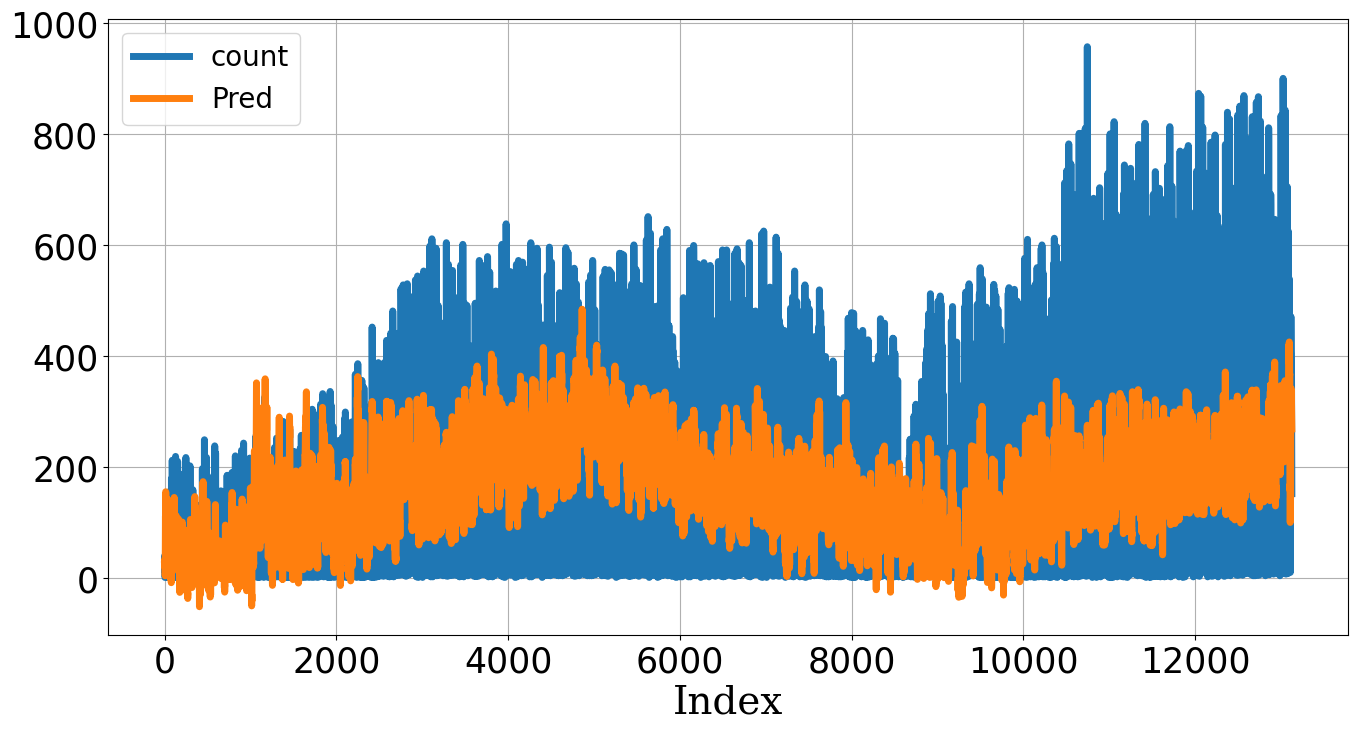

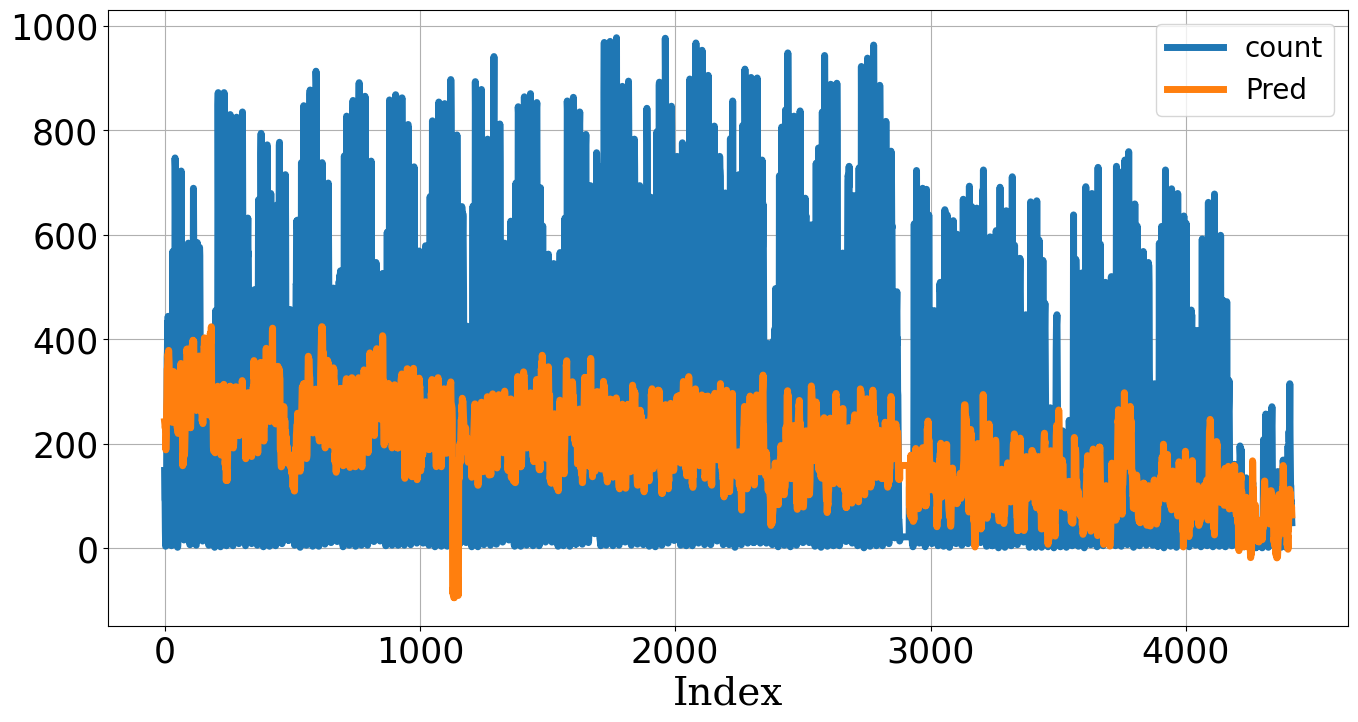

MAE       MSE  MAPE
Train 103.09 19,360.42  4.58
Test  150.03 43,410.27  3.17

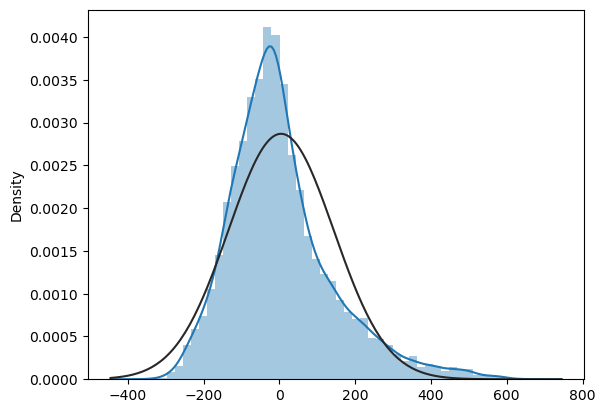

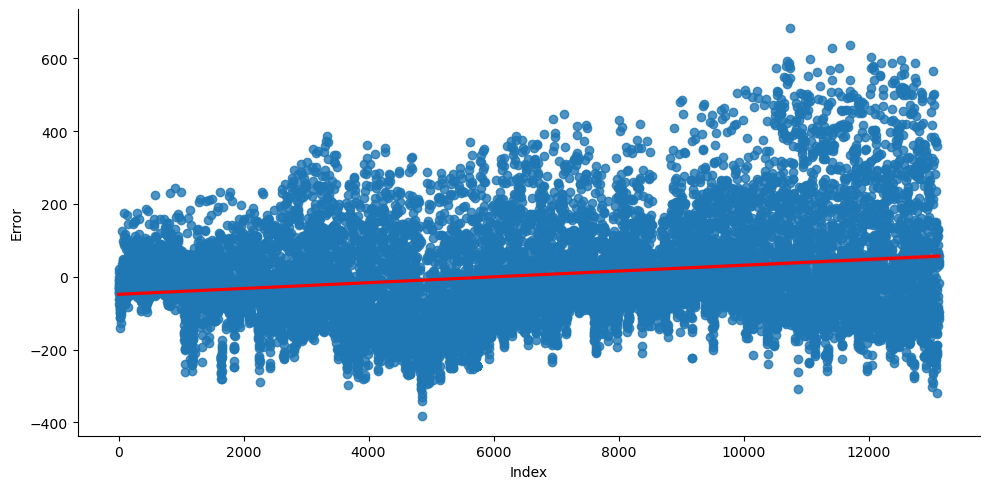

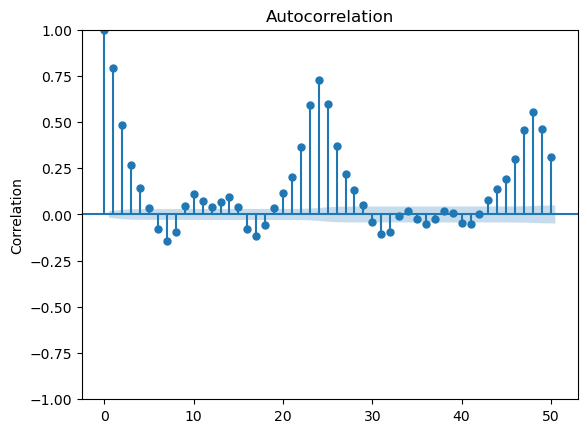

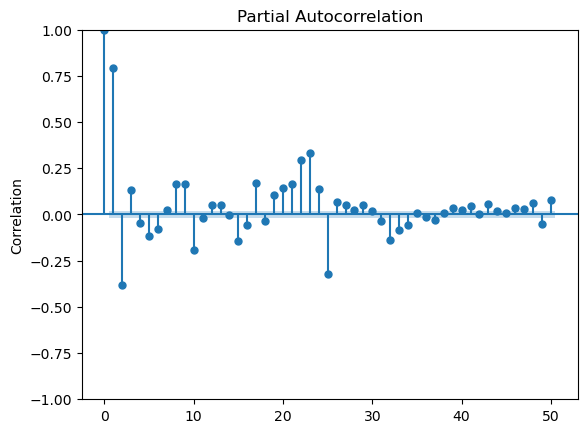

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.94               1.76        13,138.03   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics            48,485.56             -9.25              19.30  
p-value                         0.00              0.00               0.01  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             40.00              18.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

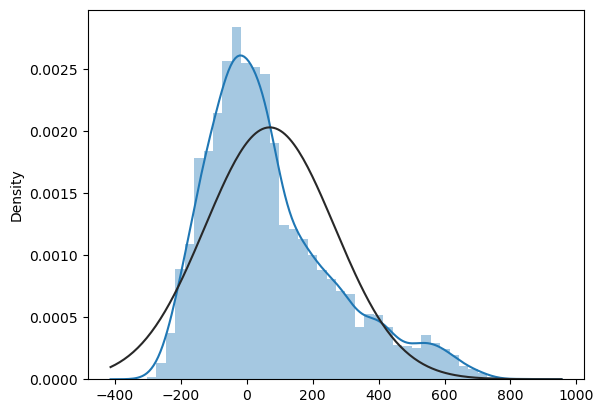

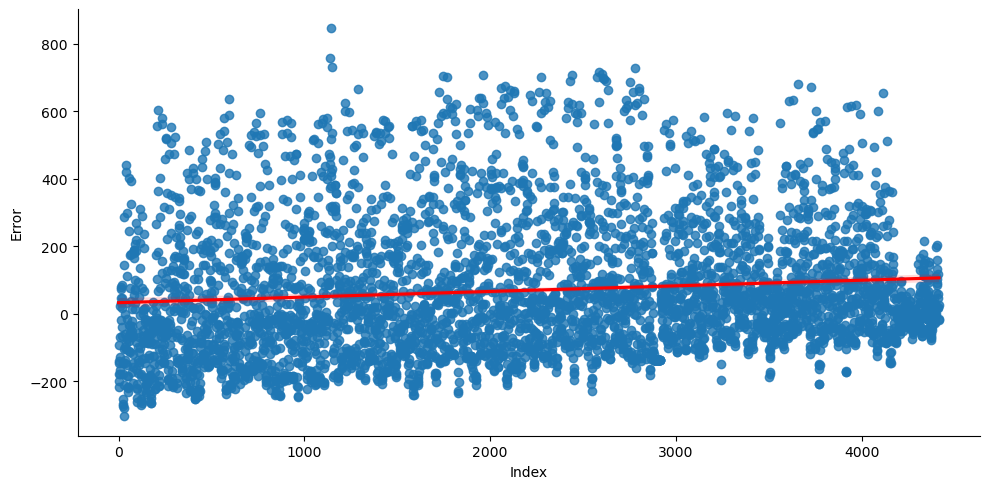

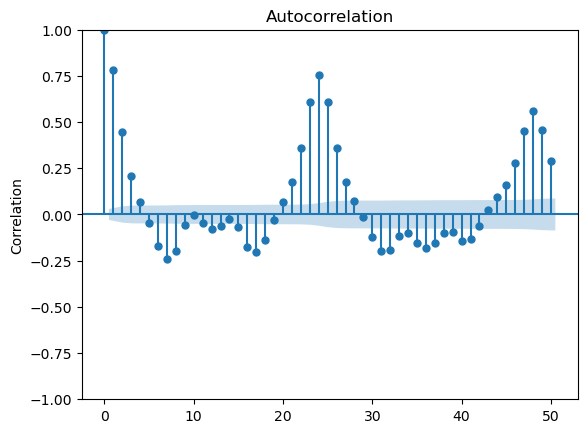

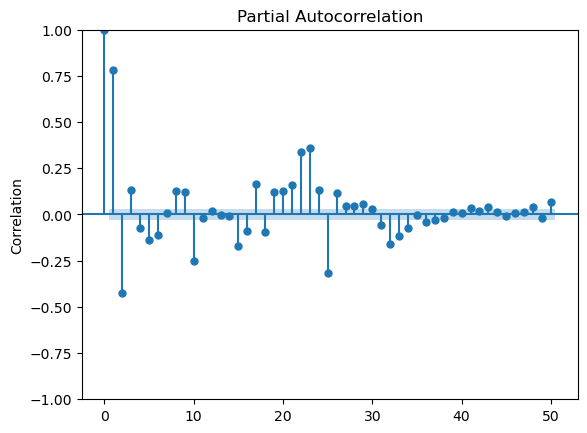

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.93               0.73         4,400.21   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics            17,427.07             -6.11               2.62  
p-value                         0.00              0.00               0.01  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             31.00              15.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

In [5]:
# 데이터 로딩
location = os.path.join('.', 'Data', 'BikeSharingDemand', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = non_feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# Linear Regression
model_lr_Raw = sm.OLS(Y_train, X_train).fit()
display(model_lr_Raw.summary())

Y_trpred = pd.DataFrame(model_lr_Raw.predict(X_train), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr_Raw.predict(X_test), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_Raw = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_Raw)

# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

## 전처리 반영 분석결과

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:40:21   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.811
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

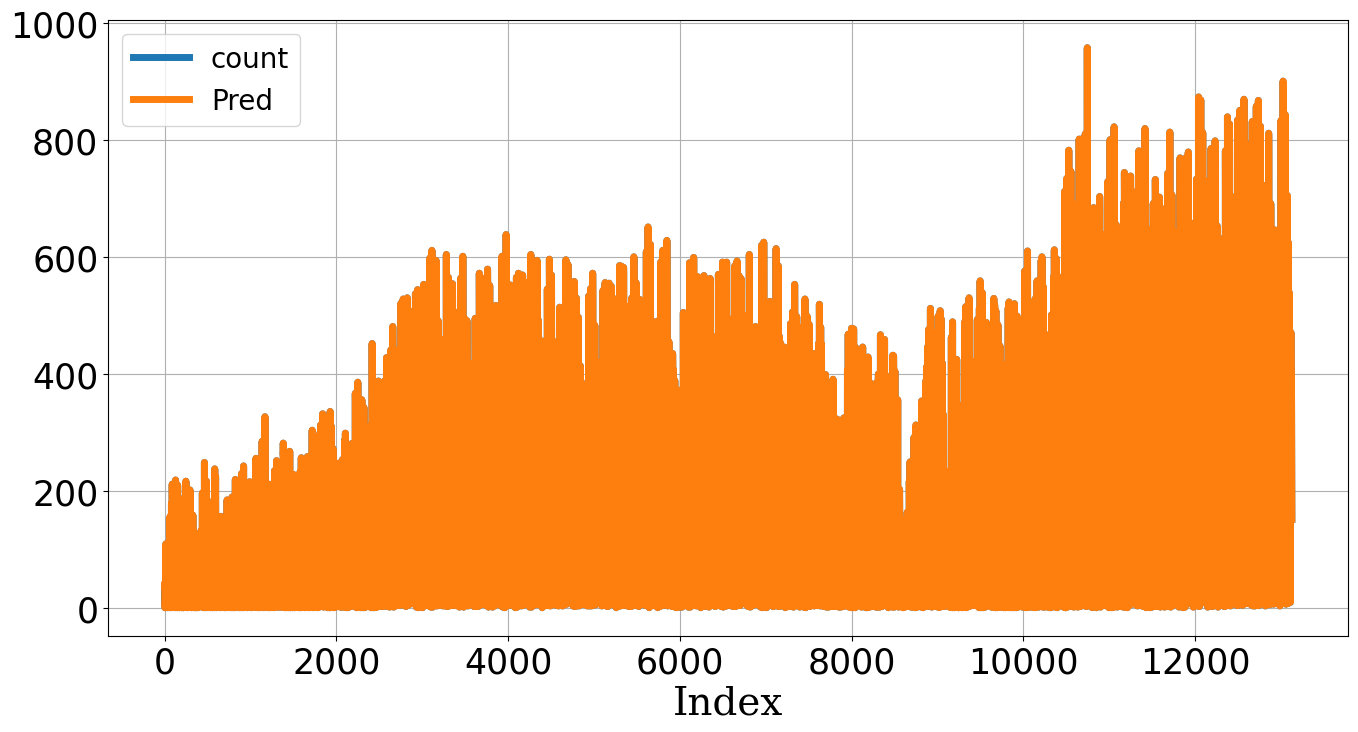

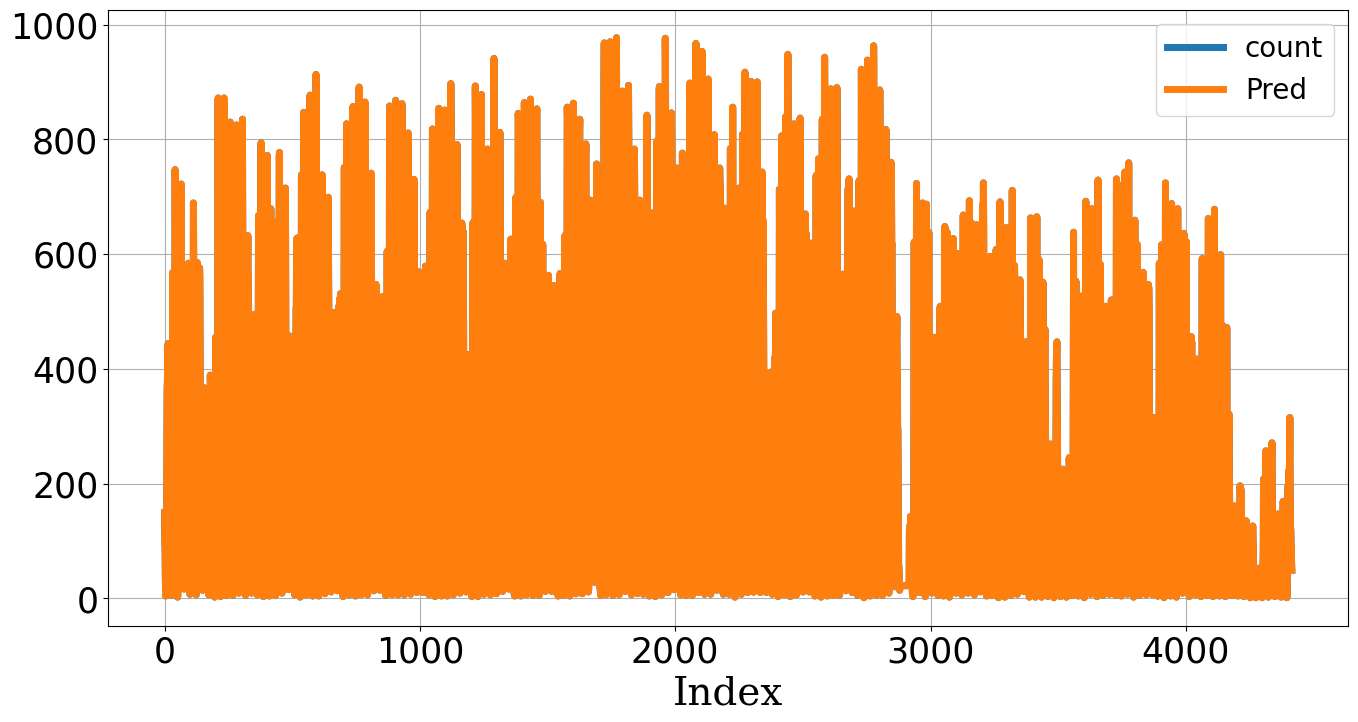

MAE  MSE  MAPE
Train 0.01 0.04  0.00
Test  0.01 0.00  0.00

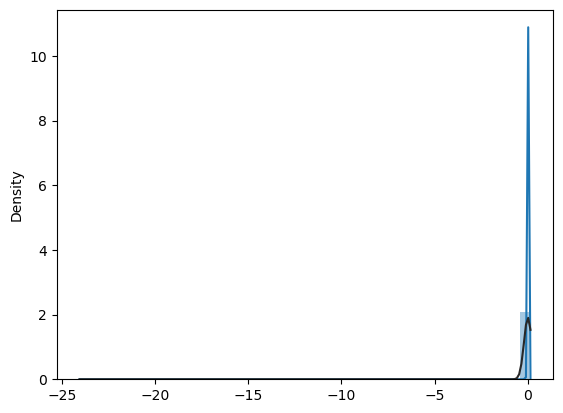

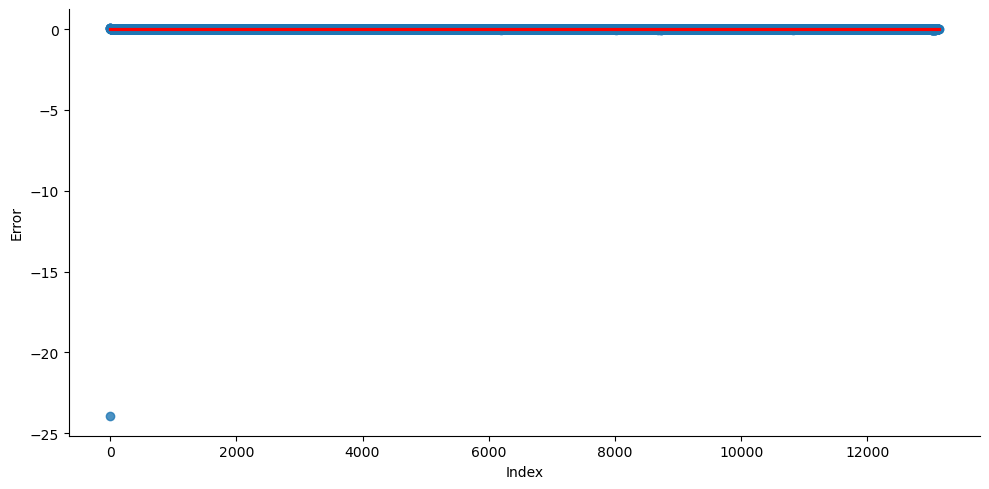

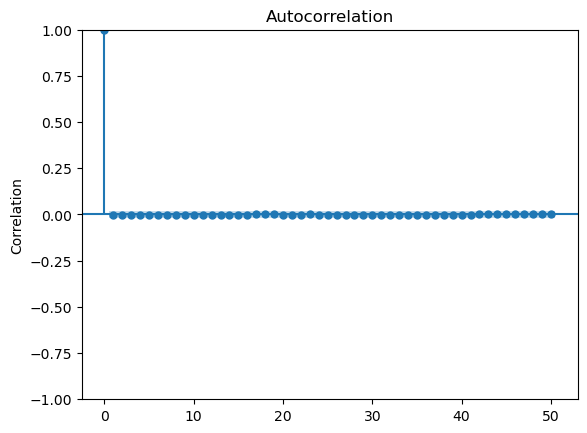

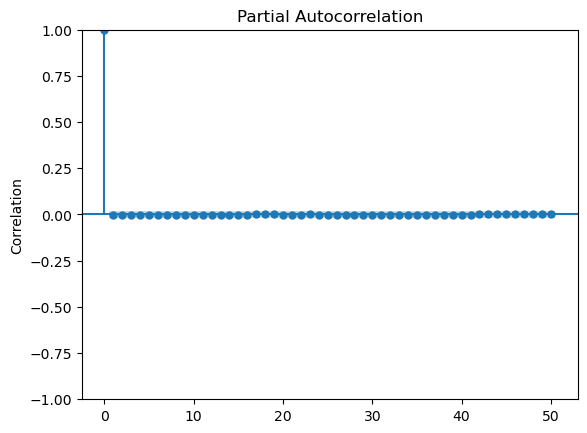

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.01               0.00             0.03   
p-value                   0.00               0.00             1.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics                 0.10             -9.98               0.09  
p-value                         1.00              0.00               0.10  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             41.00               2.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

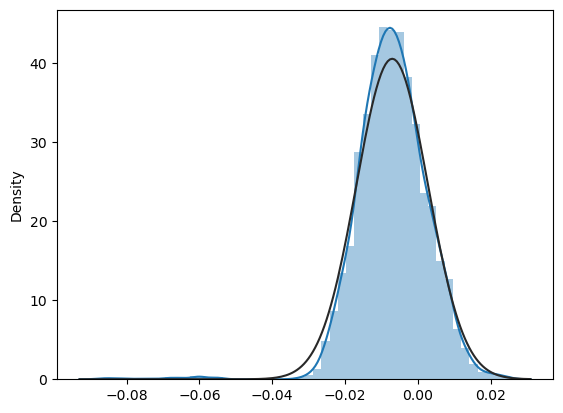

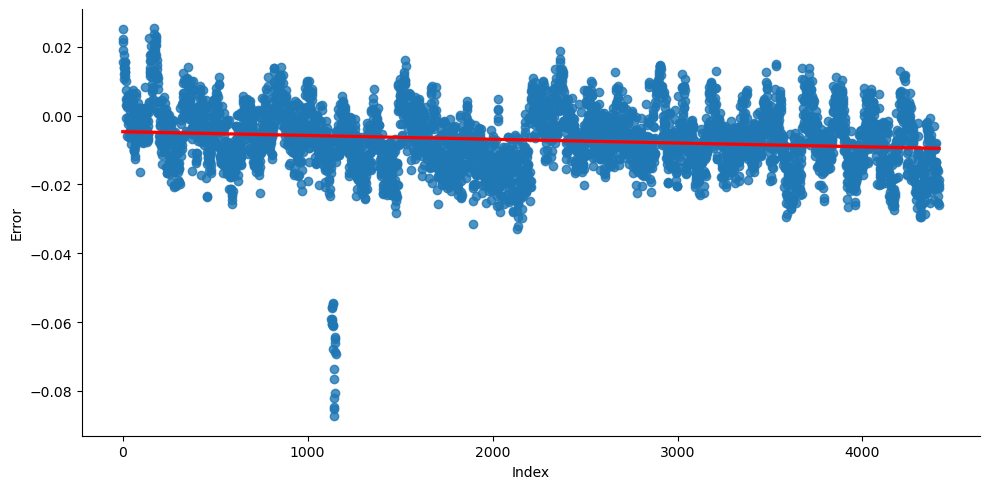

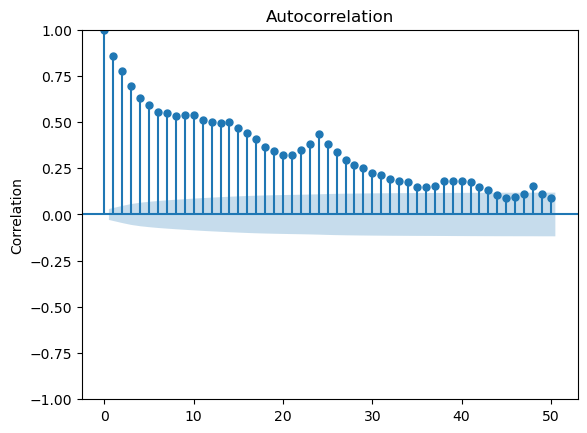

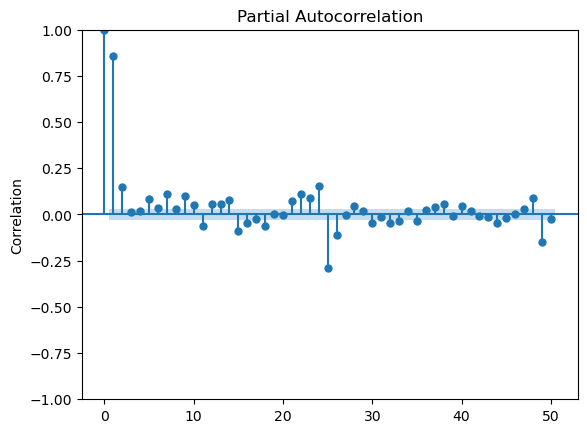

Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.93               0.50        17,815.72   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics            33,403.03             -8.08               0.51  
p-value                         0.00              0.00               0.04  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             31.00              38.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

In [6]:
# 데이터 로딩
location = os.path.join('.', 'Data', 'BikeSharingDemand', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# Linear Regression
model_lr = sm.OLS(Y_train, X_train).fit()
display(model_lr.summary())

Y_trpred = pd.DataFrame(model_lr.predict(X_train), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr.predict(X_test), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_FEHalf = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_FEHalf)

# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

In [7]:
# 검증 성능이 너무 정확하다?
Score_FEHalf

MAE  MSE  MAPE
Train 0.01 0.04  0.00
Test  0.01 0.00  0.00

# **Preprocessing Update:** 시계열 전처리 업데이트

## 시간현실 반영(Reality)

> **"미래의 시간패턴을 `미리 반영하는건 비현실적`, 이는 `과적합(Overfitting)` 유발"**
> - 데이터 전처리시, `데이터 분리 후 패턴을 추출`하여 해결

<center><img src='Image/Advanced/DataAnalysis_CycleTS3.png' width='800'></center>

---

<center><img src='Image/Advanced/DataAnalysis_CycleTS4.png' width='800'></center>

In [8]:
# Test 기간의 시계열 데이터를 알 수 있을까?
# 1) 과거의 시계열 패턴이 미래에 반복될 것이라 가정할 순 있지만 알순 없음!
# 2-1) 가장 좋은 방법은 미래 시점이 도래할 때까지 기다려서 Train 업데이트 후 Test 예측!
# 2-2) 그렇지 않으면 미래 시점을 하나씩 예측 후 예측값 자체를 Train에 반영하여 Test 예측!

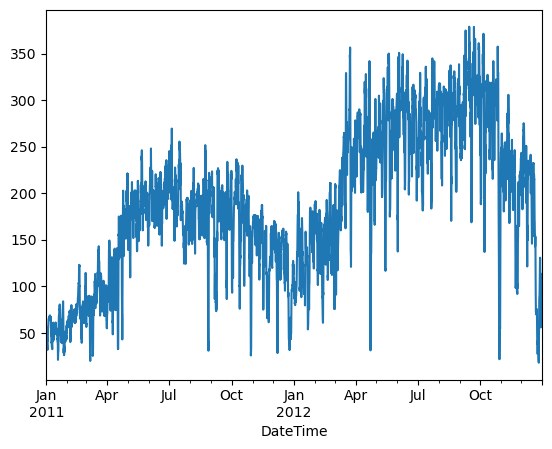

In [9]:
# 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()

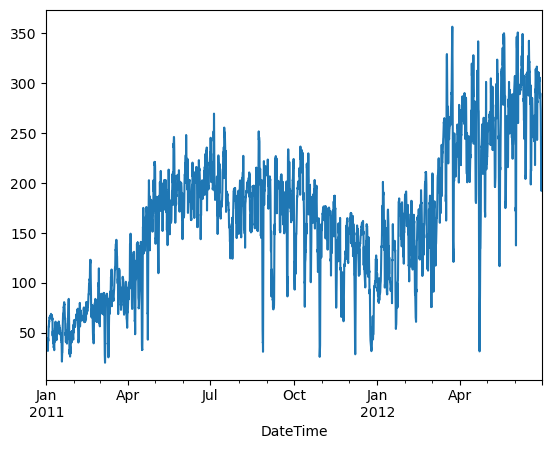

In [10]:
# 종속변수 시계열 추세 Train 확인
X_train['count_trend'].plot()
plt.show()

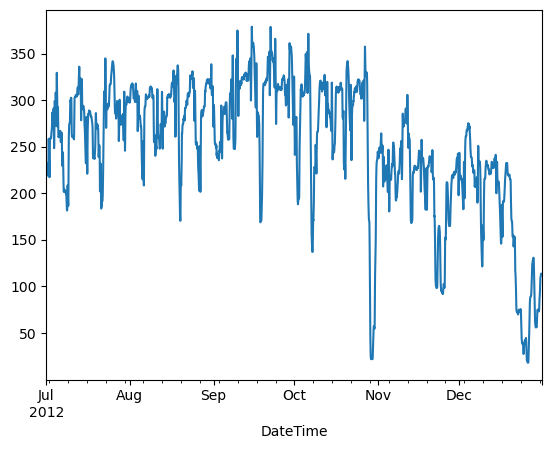

In [11]:
# 종속변수 시계열 추세 Test 확인
X_test['count_trend'].plot()
plt.show()

In [12]:
# 가정1) 2011년 7월~12월 추세가 2012년 7월~12월에도 나타날 수 있다
# 가정2) 2011년 1월~12월 추세가 2012년 1월~12월에도 나타날 수 있다

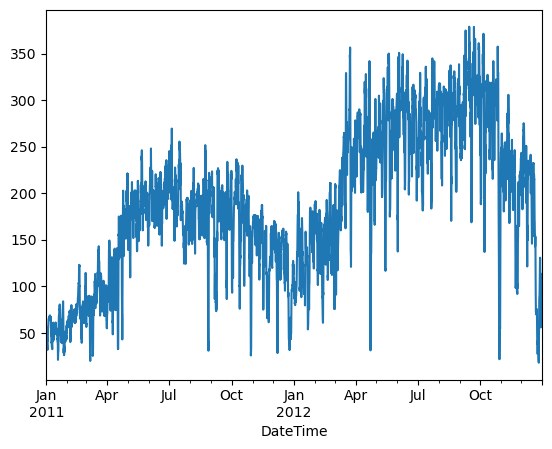

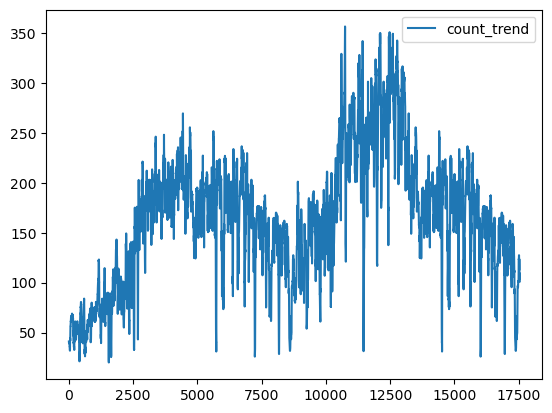

In [13]:
# 가정1의 경우로 데이터 결합시 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()
pd.concat([X_train['count_trend'], 
           X_train.loc['2011-07-01':'2011-12-31', 'count_trend']], 
          axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [14]:
# 가정2의 경우 추가적인 분석이 요구될 수 있음
len(df_fe.loc['2012-01-01':'2012-12-31', 'count_trend'])

8784

In [15]:
len(df_fe.loc['2011-01-01':'2011-12-31', 'count_trend'])

8760

In [16]:
# 2월 29일이 12년에는 존재하지만 11년에는 존재하지 않음
df_fe.loc['2012-02-29', 'count_trend']

DateTime
2012-02-29 00:00:00   139.69
2012-02-29 01:00:00   134.96
2012-02-29 02:00:00   130.96
2012-02-29 03:00:00   127.75
2012-02-29 04:00:00   123.67
                       ...  
2012-02-29 19:00:00    76.94
2012-02-29 20:00:00    87.96
2012-02-29 21:00:00   103.08
2012-02-29 22:00:00   110.81
2012-02-29 23:00:00   116.67
Freq: H, Name: count_trend, Length: 24, dtype: float64

In [17]:
# # 2월 29일이 12년에는 존재하지만 11년에는 존재하지 않음
# df_fe.loc['2011-02-29', 'count_trend']

In [18]:
X_test

season  holiday  workingday  weather  temp  atemp  \
DateTime                                                                 
2012-07-01 00:00:00       3        0           0        1 31.16  36.37   
2012-07-01 01:00:00       3        0           0        1 30.34  34.85   
2012-07-01 02:00:00       3        0           0        1 29.52  34.85   
2012-07-01 03:00:00       3        0           0        1 29.52  35.60   
2012-07-01 04:00:00       3        0           0        1 28.70  33.34   
...                     ...      ...         ...      ...   ...    ...   
2012-12-31 19:00:00       1        0           1        2 10.66  12.88   
2012-12-31 20:00:00       1        0           1        2 10.66  12.88   
2012-12-31 21:00:00       1        0           1        1 10.66  12.88   
2012-12-31 22:00:00       1        0           1        1 10.66  13.63   
2012-12-31 23:00:00       1        0           1        1 10.66  13.63   

                     humidity  windspeed  count_trend  count_seasonal  ...  \
DateTime                                                               ...   
2012-07-01 00:00:00        66       0.00       230.42         -134.25  ...   
2012-07-01 01:00:00        70       9.00       229.46         -154.75  ...   
2012-07-01 02:00:00        74       6.00       230.02         -165.27  ...   
2012-07-01 03:00:00        84       9.00       229.52         -176.48  ...   
2012-07-01 04:00:00        79      13.00       227.04         -181.67  ...   
...                       ...        ...          ...             ...  ...   
2012-12-31 19:00:00        60      11.00       113.71          122.70  ...   
2012-12-31 20:00:00        60      11.00       113.71           37.48  ...   
2012-12-31 21:00:00        60      11.00       113.71          -16.10  ...   
2012-12-31 22:00:00        56       9.00       113.71          -56.94  ...   
2012-12-31 23:00:00        65       9.00       113.71         -100.31  ...   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2012-07-01 00:00:00            7      7    1     0          6      152.00   
2012-07-01 01:00:00            7      7    1     1          6      149.00   
2012-07-01 02:00:00            7      7    1     2          6       93.00   
2012-07-01 03:00:00            7      7    1     3          6       90.00   
2012-07-01 04:00:00            7      7    1     4          6       33.00   
...                          ...    ...  ...   ...        ...         ...   
2012-12-31 19:00:00            8     12   31    19          0      122.00   
2012-12-31 20:00:00            8     12   31    20          0      119.00   
2012-12-31 21:00:00            8     12   31    21          0       89.00   
2012-12-31 22:00:00            8     12   31    22          0       90.00   
2012-12-31 23:00:00            8     12   31    23          0       61.00   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2012-07-01 00:00:00      172.00               0               1   
2012-07-01 01:00:00      152.00               0               1   
2012-07-01 02:00:00      149.00               0               1   
2012-07-01 03:00:00       93.00               0               1   
2012-07-01 04:00:00       90.00               0               1   
...                         ...             ...             ...   
2012-12-31 19:00:00      164.00               0               0   
2012-12-31 20:00:00      122.00               0               0   
2012-12-31 21:00:00      119.00               0               0   
2012-12-31 22:00:00       89.00               0               0   
2012-12-31 23:00:00       90.00               0               0   

                     Quater_Dummy_4  
DateTime                             
2012-07-01 00:00:00               0  
2012-07-01 01:00:00               0  
2012-07-01 02:00:

In [19]:
# 수동으로 반영 필요
X_train.loc['2012-01-01':'2012-02-28', 'count_trend'] = X_train.loc['2011-01-01':'2011-02-28', 'count_trend'].values
X_train.loc['2012-03-01':'2012-06-30', 'count_trend'] = X_train.loc['2011-03-01':'2011-06-30', 'count_trend'].values
X_test.loc['2012-07-01':'2012-12-31', 'count_trend'] = X_train.loc['2011-07-01':'2011-12-31', 'count_trend'].values

In [20]:
# 2012-02-29??
X_train.loc['2011-02-28 23:00:00':'2011-03-01', 'count_trend']

DateTime
2011-02-28 23:00:00   56.48
2011-03-01 00:00:00   56.88
2011-03-01 01:00:00   58.88
2011-03-01 02:00:00   60.96
2011-03-01 03:00:00   62.69
                       ... 
2011-03-01 19:00:00   77.15
2011-03-01 20:00:00   78.08
2011-03-01 21:00:00   79.46
2011-03-01 22:00:00   80.12
2011-03-01 23:00:00   80.65
Freq: H, Name: count_trend, Length: 25, dtype: float64

In [21]:
# 단순하게 2월 28일 마지막 값과 3월 1일 첫번째 값의 간격을 24등분하여 2월 29일 값을 생성
# 일반적으로 내부 값을 이어서 채운다고 하여 interpolation 방법이라고 하며,
# 정교하게는 2월 28일까지의 데이터로 2월 29일 데이터를 별도 예측하여 반영
step = (X_train.loc['2011-03-01 00:00:00', 'count_trend'] - X_train.loc['2011-02-28 23:00:00', 'count_trend'])/25
step_value = np.arange(X_train.loc['2011-02-28 23:00:00', 'count_trend']+step, 
                       X_train.loc['2011-03-01 00:00:00', 'count_trend'], step)
step_value = step_value[:24]
X_train.loc['2012-02-29', 'count_trend'] = step_value

In [22]:
# 12년 2월 29일 생성 데이터 확인
X_train.loc['2012-02-28 22:00:00':'2012-03-01 02:00:00', 'count_trend']

DateTime
2012-02-28 22:00:00   57.62
2012-02-28 23:00:00   56.48
2012-02-29 00:00:00   56.49
2012-02-29 01:00:00   56.51
2012-02-29 02:00:00   56.53
                       ... 
2012-02-29 22:00:00   56.84
2012-02-29 23:00:00   56.86
2012-03-01 00:00:00   56.88
2012-03-01 01:00:00   58.88
2012-03-01 02:00:00   60.96
Freq: H, Name: count_trend, Length: 29, dtype: float64

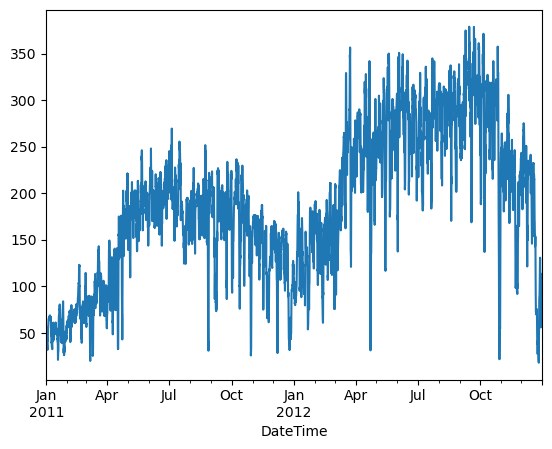

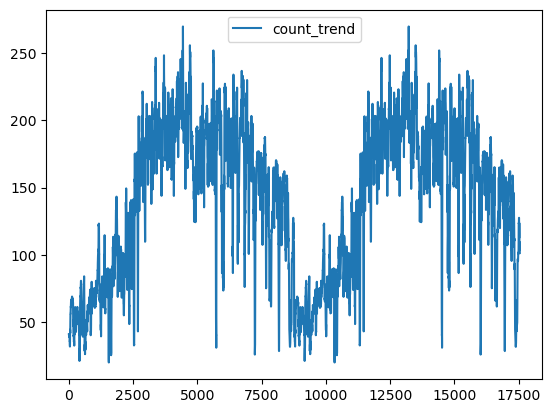

In [23]:
# 가정2의 경우로 데이터 결합시 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()
pd.concat([X_train['count_trend'], 
           X_test['count_trend']], 
          axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [24]:
# 2011년 데이터 시계열 패턴으로 2012년 데이터로 가정
def feature_engineering_year_duplicated(X_train, X_test, target):
    X_train_R, X_test_R = X_train.copy(), X_test.copy()
    for col in target:
        X_train_R.loc['2012-01-01':'2012-02-28', col] = X_train_R.loc['2011-01-01':'2011-02-28', col].values
        X_train_R.loc['2012-03-01':'2012-06-30', col] = X_train_R.loc['2011-03-01':'2011-06-30', col].values
        X_test_R.loc['2012-07-01':'2012-12-31', col] = X_train_R.loc['2011-07-01':'2011-12-31', col].values
        
        step = (X_train_R.loc['2011-03-01 00:00:00', col] - X_train_R.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(X_train_R.loc['2011-02-28 23:00:00', col]+step, 
                               X_train_R.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        X_train_R.loc['2012-02-29', col] = step_value

    return X_train_R, X_test_R

target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)

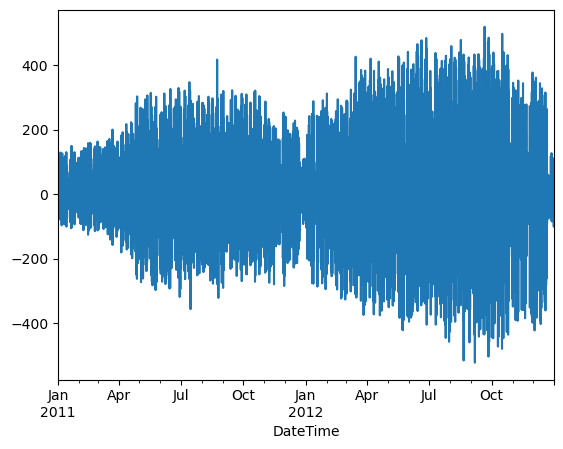

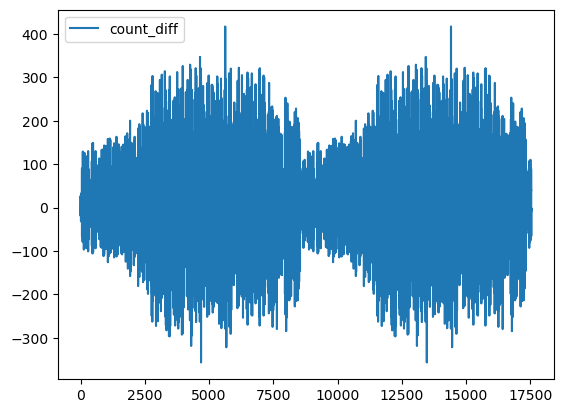

In [25]:
# 가정2의 경우로 데이터 결합시 종속변수 시계열 차분 전체 확인
df_fe['count_diff'].plot()
plt.show()
pd.concat([X_train_R['count_diff'], 
           X_test_R['count_diff']], 
          axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [26]:
# count_lag1, count_lag2 지연값은 어떻게 처리?
# X_test의 일부 데이터응 X_train에서 넘어온 값
# 가정하여 사용할 순 있지만 분할 후 전처리 방식은 아님!
X_test_R.head()

season  holiday  workingday  weather  temp  atemp  \
DateTime                                                                 
2012-07-01 00:00:00       3        0           0        1 31.16  36.37   
2012-07-01 01:00:00       3        0           0        1 30.34  34.85   
2012-07-01 02:00:00       3        0           0        1 29.52  34.85   
2012-07-01 03:00:00       3        0           0        1 29.52  35.60   
2012-07-01 04:00:00       3        0           0        1 28.70  33.34   

                     humidity  windspeed  count_trend  count_seasonal  ...  \
DateTime                                                               ...   
2012-07-01 00:00:00        66       0.00       228.46         -134.25  ...   
2012-07-01 01:00:00        70       9.00       230.33         -154.75  ...   
2012-07-01 02:00:00        74       6.00       234.50         -165.27  ...   
2012-07-01 03:00:00        84       9.00       240.35         -176.48  ...   
2012-07-01 04:00:00        79      13.00       245.46         -181.67  ...   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2012-07-01 00:00:00            7      7    1     0          6      152.00   
2012-07-01 01:00:00            7      7    1     1          6      149.00   
2012-07-01 02:00:00            7      7    1     2          6       93.00   
2012-07-01 03:00:00            7      7    1     3          6       90.00   
2012-07-01 04:00:00            7      7    1     4          6       33.00   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2012-07-01 00:00:00      172.00               0               1   
2012-07-01 01:00:00      152.00               0               1   
2012-07-01 02:00:00      149.00               0               1   
2012-07-01 03:00:00       93.00               0               1   
2012-07-01 04:00:00       90.00               0               1   

                     Quater_Dummy_4  
DateTime                             
2012-07-01 00:00:00               0  
2012-07-01 01:00:00               0  
2012-07-01 02:00:00               0  
2012-07-01 03:00:00               0  
2012-07-01 04:00:00               0  

[5 rows x 24 columns]

In [27]:
# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채워야 함
Y_test.shift(2)

count
DateTime                  
2012-07-01 00:00:00    NaN
2012-07-01 01:00:00    NaN
2012-07-01 02:00:00 149.00
2012-07-01 03:00:00  93.00
2012-07-01 04:00:00  90.00
...                    ...
2012-12-31 19:00:00 164.00
2012-12-31 20:00:00 122.00
2012-12-31 21:00:00 119.00
2012-12-31 22:00:00  89.00
2012-12-31 23:00:00  90.00

[4416 rows x 1 columns]

In [28]:
# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채워야 함
X_test_R['count_lag1'] = Y_test.shift(1).values
X_test_R['count_lag1'].fillna(method='bfill', inplace=True)
X_test_R['count_lag2'] = Y_test.shift(2).values
X_test_R['count_lag2'].fillna(method='bfill', inplace=True)
X_test_R['count_lag2']

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count_lag2, Length: 4416, dtype: float64

In [29]:
# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채움
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_R = X_test.copy()
    for col in target:
        X_test_R[col] = Y_test.shift(1).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        X_test_R[col] = Y_test.shift(2).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        
    return X_test_R

target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)

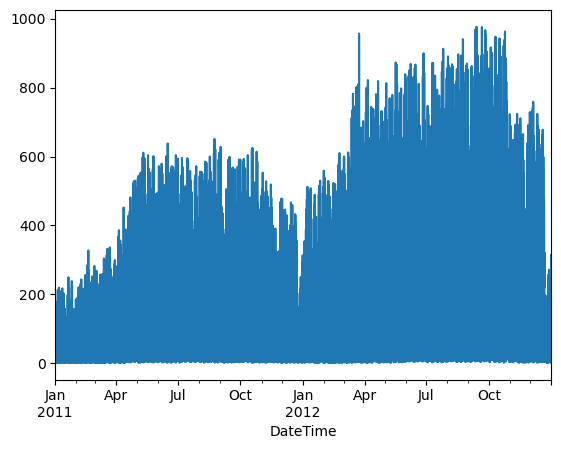

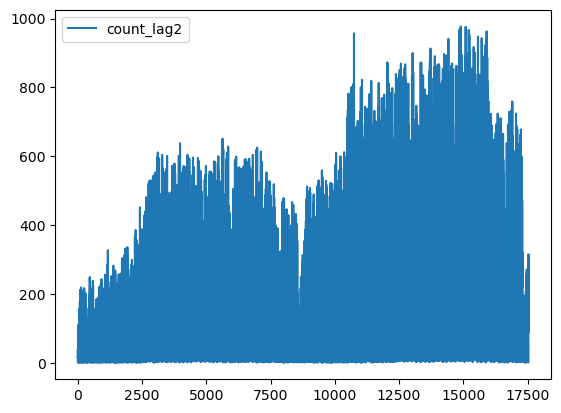

In [30]:
# 가정2의 경우로 데이터 결합시 종속변수 시계열 차분 전체 확인
df_fe['count_lag2'].plot()
plt.show()
pd.concat([X_train_R['count_lag2'], 
           X_test_R['count_lag2']], 
          axis=0).reset_index().iloc[:,1:].plot()
plt.show()

### Code Summary

In [31]:
# 2011년 데이터 시계열 패턴으로 2012년 데이터로 가정
def feature_engineering_year_duplicated(X_train, X_test, target):
    X_train_R, X_test_R = X_train.copy(), X_test.copy()
    for col in target:
        X_train_R.loc['2012-01-01':'2012-02-28', col] = X_train_R.loc['2011-01-01':'2011-02-28', col].values
        X_train_R.loc['2012-03-01':'2012-06-30', col] = X_train_R.loc['2011-03-01':'2011-06-30', col].values
        X_test_R.loc['2012-07-01':'2012-12-31', col] = X_train_R.loc['2011-07-01':'2011-12-31', col].values
        
        step = (X_train_R.loc['2011-03-01 00:00:00', col] - X_train_R.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(X_train_R.loc['2011-02-28 23:00:00', col]+step, 
                               X_train_R.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        X_train_R.loc['2012-02-29', col] = step_value

    return X_train_R, X_test_R


# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채움
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_R = X_test.copy()
    for col in target:
        X_test_R[col] = Y_test.shift(1).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        X_test_R[col] = Y_test.shift(2).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        
    return X_test_R

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:40:40   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             2.7535      0.952      2.893      0.004       0.888       4.619
holiday            0.6180      3.170      0.195      0.845      -5.595       6.831
workingday         2.1960      1.544      1.423      0.155      -0.830       5.222
weather           -5.8817      0.780     -7.544      0.000      -7.410      -4.353
temp               0.5622      0.490      1.146      0.252      -0.399       1.523
atemp              0.4042      0.427      0.946      0.344      -0.433       1.242
humidity          -0.0706      0.028     -2.501      0.012      -0.126      -0.015
windspeed         -0.1216      0.057     -2.117      0.034      -0.234      -0.009
count_trend        0.0718      0.024      3.007      0.003       0.025       0.119
count_seasonal     0.1948      0.006     34.600      0.000       0.184       0.206
count_Day          0.1011      0.024      4.190      0.000       0.054       0.148
count_Week        -0.0801      0.026     -3.078      0.002      -0.131      -0.029
count_diff         0.7146      0.007     97.737      0.000       0.700       0.729
Year               0.0004      0.002      0.188      0.851      -0.003       0.004
Quater_ver2        5.6849      0.284     19.988      0.000       5.127       6.242
Month              1.1013      0.566      1.945      0.052      -0.009       2.211
Day               -0.0335      0.049     -0.681      0.496      -0.130       0.063
Hour               0.1185      0.083      1.420      0.156      -0.045       0.282
DayofWeek          0.3611      0.354      1.021      0.307      -0.332       1.055
count_lag1         0.9285      0.006    149.851      0.000       0.916       0.941
count_lag2        -0.1938      0.006    -33.734      0.000      -0.205      -0.183
Quater_Dummy_2    -7.2671      2.213     -3.284      0.001     -11.605      -2.929
Quater_Dummy_3   -21.5188      3.728     -5.773      0.000     -28.825     -14.212
Quater_Dummy_4   -26.7509      5.511     -4.854      0.000     -37.554     -15.948
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

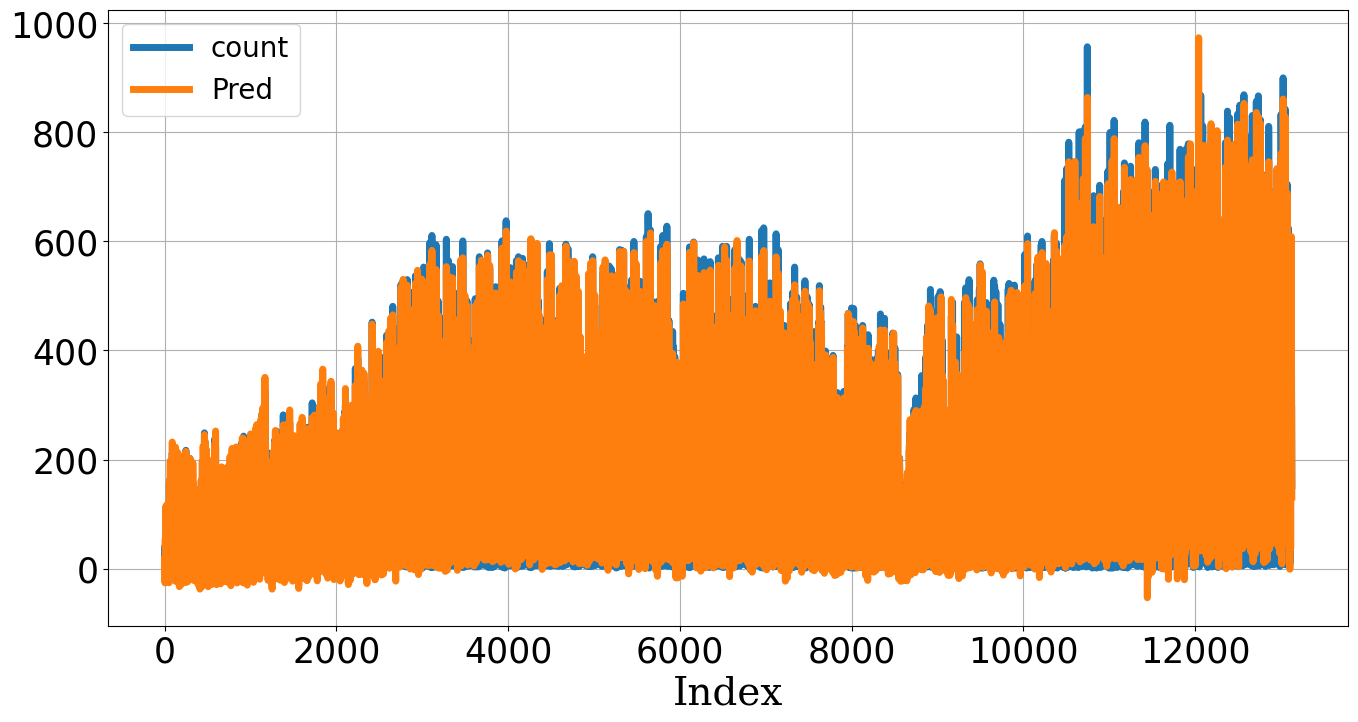

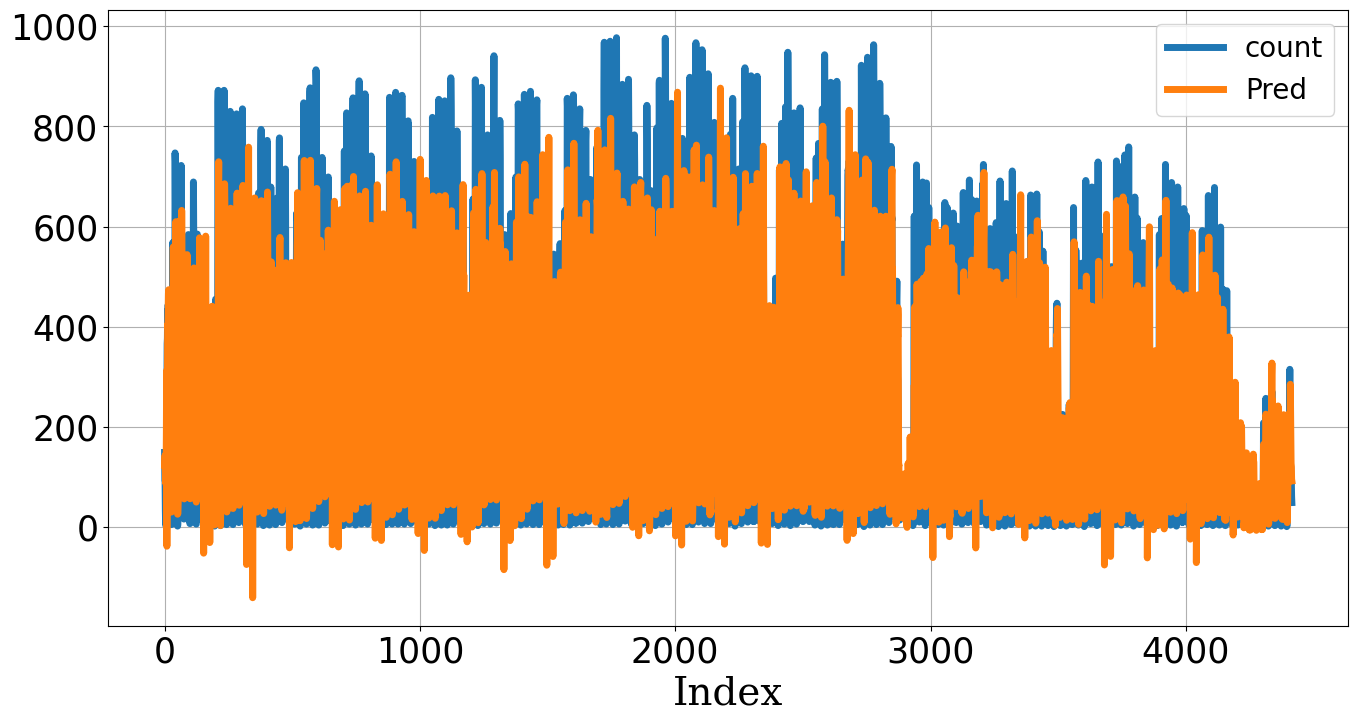

MAE       MSE  MAPE
Train  27.79  2,364.05  0.82
Test  113.99 26,316.17  1.34

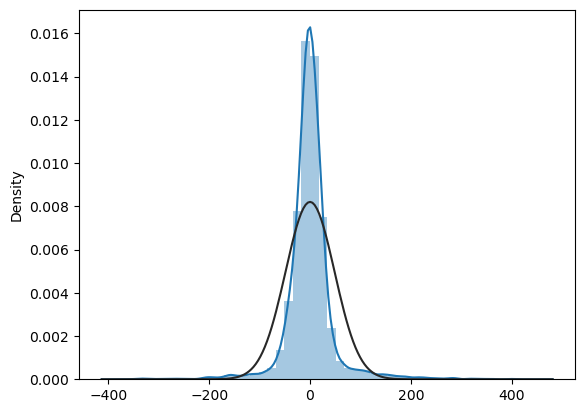

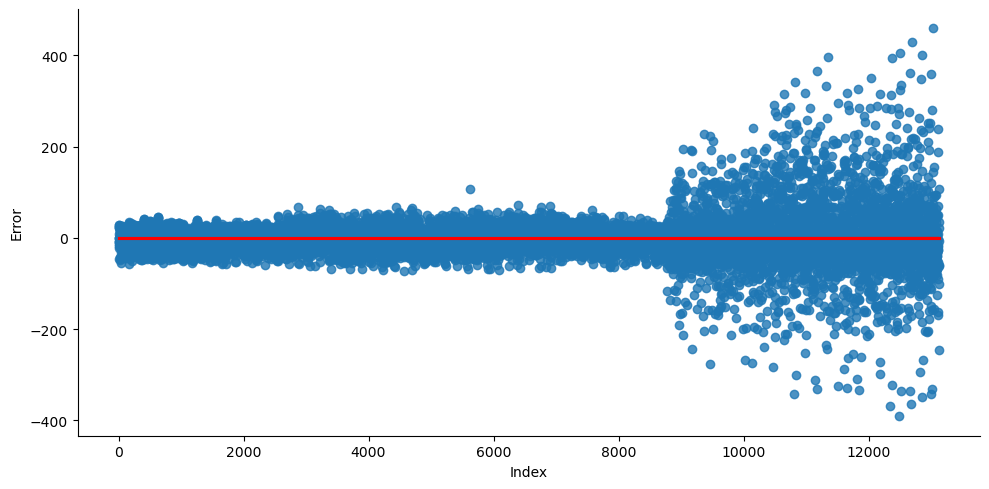

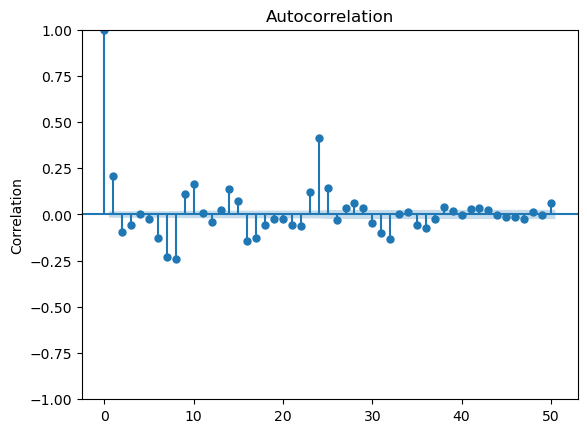

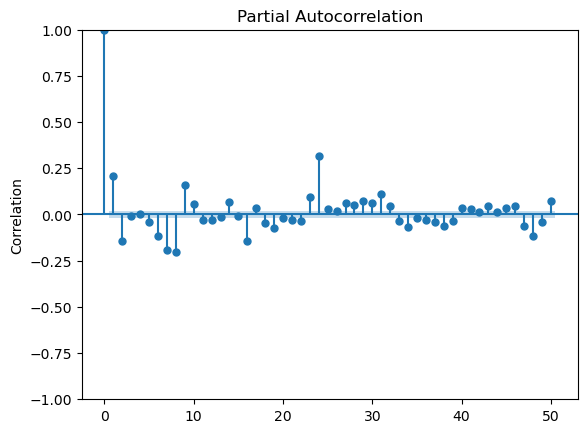

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.78          16,218.77         2,927.28   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics             7,390.92            -13.45               0.06  
p-value                         0.00              0.00               0.10  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             41.00             460.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

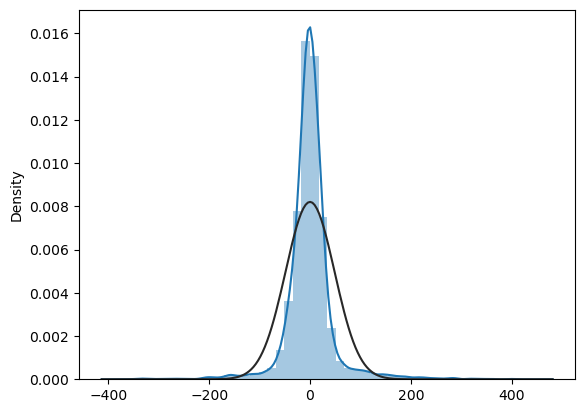

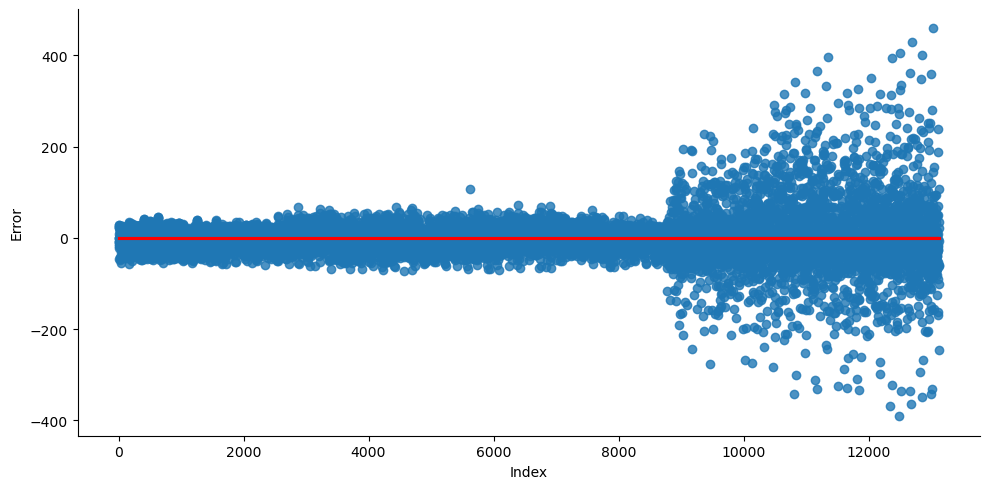

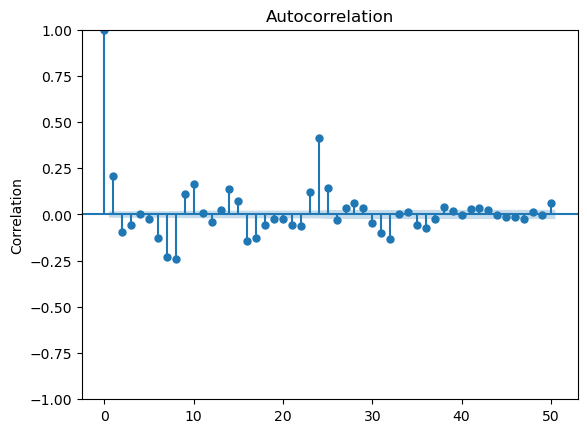

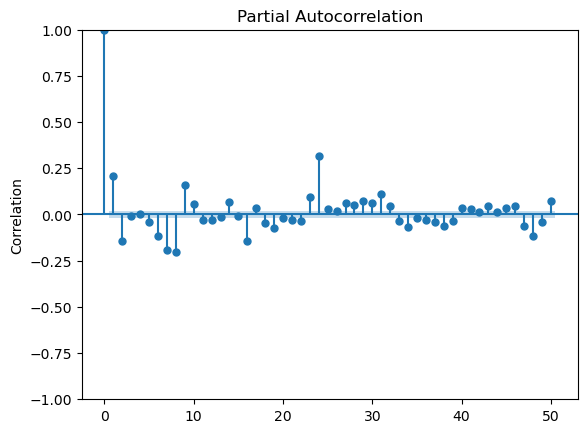

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.78          16,218.77         2,927.28   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics             7,390.92            -13.45               0.06  
p-value                         0.00              0.00               0.10  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             41.00             460.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

In [32]:
# 데이터 로딩
location = os.path.join('.', 'Data', 'BikeSharingDemand', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############

# Linear Regression
model_lr_R = sm.OLS(Y_train, X_train_R).fit()
display(model_lr_R.summary())

Y_trpred_R = pd.DataFrame(model_lr_R.predict(X_train_R), columns=['Pred'])
Y_tepred_R = pd.DataFrame(model_lr_R.predict(X_test_R), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred_R], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred_R], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_R = evaluation_reg_trte(Y_train, Y_trpred_R, Y_test, Y_tepred_R)
display(Score_R)

# 에러 분석
Resid_tr = Y_train - Y_trpred_R.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred_R.values
Resid_te.columns = ['Error']

Error_tr_R = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr_R)
Error_te_R = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_te_R)

In [33]:
# 전처리 결과에 따른 성능 비교
display(Score_Raw)
display(Score_FEHalf)
display(Score_R)

MAE       MSE  MAPE
Train 103.09 19,360.42  4.58
Test  150.03 43,410.27  3.17

MAE  MSE  MAPE
Train 0.01 0.04  0.00
Test  0.01 0.00  0.00

MAE       MSE  MAPE
Train  27.79  2,364.05  0.82
Test  113.99 26,316.17  1.34

## 스케일 조정(Scaling)

- **목적:** 변수들의 `크기를 일정하게 맞추어` `크기` 때문에 `영향`이 높은 현상을 회피

> - **수학적:** 독립 변수의 공분산 `행렬 조건수(Condition Number)를 감소`시켜 최적화 안정성 및 수렴 속도 향상 
> - **컴퓨터적:** PC 메모리를 고려하여 `오버플로우(Overflow)나 언더플로우(Underflow)를 줄여줌` 
    

**1) Standard Scaler:** <center>$\dfrac{X_{it} - E(X_i)}{SD(X_i)}$</center>
> - 기본 스케일로 평균을 제외하고 표준편차를 나누어 변환  
> - 각 변수(Feature)가 `정규분포를 따른다는 가정`이기에 정규분포가 아닐 시 최선이 아닐 수 있음  
>
> ```python
> sklearn.preprocessing.StandardScaler().fit()
> sklearn.preprocessing.StandardScaler().transform()
> sklearn.preprocessing.StandardScaler().fit_transform()
> ```

<center><img src='Image/Advanced/Scaling_StandardScaler.png' width='500'></center>

**2) Min-Max Scaler:** <center>$\dfrac{X_{it} - min(X_i)}{max(X_i) - min(X_i)}$</center>
> - 가장 많이 활용되는 방식으로 최소\~최대 값이 `0~1` 또는 `-1~1` 사이의 값으로 변환  
> - 각 변수(Feature)가 `정규분포가 아니거나 표준편차가 매우 작을 때` 효과적 
>
> ```python
> sklearn.preprocessing.MinMaxScaler().fit()
> sklearn.preprocessing.MinMaxScaler().transform()
> sklearn.preprocessing.MinMaxScaler().fit_transform()
> ```

<center><img src='Image/Advanced/Scaling_MinMaxScaler.png' width='500'></center>

**3) Robust Scaler:** <center>$\dfrac{X_{it} - Q_1(X_i)}{Q_3(X_i) - Q_1(X_i)}$</center>
> - 최소-최대 스케일러와 유사하지만 `최소/최대 대신`에 IQR(Interquartile Range) 중 `25%값/75%값`을 사용하여 변환  
> - 이상치(Outlier)에 영향을 최소화하였기에 `이상치가 있는 데이터에 효과적`이고 `적은 데이터에도 효과적`인 편  
>
> ```python
> sklearn.preprocessing.RobustScaler().fit()
> sklearn.preprocessing.RobustScaler().transform()
> sklearn.preprocessing.RobustScaler().fit_transform()
> ```

<center><img src='Image/Advanced/Scaling_RobustScaler.png' width='500'></center>

**4) Normalizer:** <center>$\dfrac{X_{it}}{\sqrt{X_{i}^2 + X_{j}^2 + ... + X_{k}^2}}$</center>
> - 각 변수(Feature)를 전체 `n`개 `모든 변수들의 크기들로 나누어`서 변환(by Cartesian Coordinates)  
> - 각 변수들의 값은 `원점으로부터 반지름 1만큼 떨어진 범위 내`로 변환  
>
> ```python
> sklearn.preprocessing.Normalizer().fit()
> sklearn.preprocessing.Normalizer().transform()
> sklearn.preprocessing.Normalizer().fit_transform()
> ```

<center><img src='Image/Advanced/Scaling_Normalizer.png' width='500'></center>

In [34]:
# X_train 데이터의 수치 크기 범위를 확인해보기
X_train_R

season  holiday  workingday  weather  temp  atemp  \
DateTime                                                                 
2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
2011-01-01 03:00:00       1        0           0        1  9.84  14.39   
2011-01-01 04:00:00       1        0           0        1  9.84  14.39   
...                     ...      ...         ...      ...   ...    ...   
2012-06-30 19:00:00       3        0           0        1 34.44  37.88   
2012-06-30 20:00:00       3        0           0        1 33.62  38.63   
2012-06-30 21:00:00       3        0           0        1 33.62  38.63   
2012-06-30 22:00:00       3        0           0        1 31.98  37.12   
2012-06-30 23:00:00       3        0           0        1 31.98  37.12   

                     humidity  windspeed  count_trend  count_seasonal  ...  \
DateTime                                                               ...   
2011-01-01 00:00:00        81       0.00        41.06         -134.25  ...   
2011-01-01 01:00:00        80       0.00        41.06         -154.75  ...   
2011-01-01 02:00:00        80       0.00        41.06         -165.27  ...   
2011-01-01 03:00:00        75       0.00        41.06         -176.48  ...   
2011-01-01 04:00:00        75       0.00        41.06         -181.67  ...   
...                       ...        ...          ...             ...  ...   
2012-06-30 19:00:00        44      17.00       228.60          122.70  ...   
2012-06-30 20:00:00        52      11.00       225.69           37.48  ...   
2012-06-30 21:00:00        52      11.00       224.38          -16.10  ...   
2012-06-30 22:00:00        62      11.00       225.17          -56.94  ...   
2012-06-30 23:00:00        62       6.00       226.90         -100.31  ...   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 00:00:00            1      1    1     0          5       16.00   
2011-01-01 01:00:00            1      1    1     1          5       16.00   
2011-01-01 02:00:00            1      1    1     2          5       40.00   
2011-01-01 03:00:00            1      1    1     3          5       32.00   
2011-01-01 04:00:00            1      1    1     4          5       13.00   
...                          ...    ...  ...   ...        ...         ...   
2012-06-30 19:00:00            6      6   30    19          5      339.00   
2012-06-30 20:00:00            6      6   30    20          5      374.00   
2012-06-30 21:00:00            6      6   30    21          5      292.00   
2012-06-30 22:00:00            6      6   30    22          5      213.00   
2012-06-30 23:00:00            6      6   30    23          5      172.00   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2011-01-01 00:00:00       16.00               0               0   
2011-01-01 01:00:00       16.00               0               0   
2011-01-01 02:00:00       16.00               0               0   
2011-01-01 03:00:00       40.00               0               0   
2011-01-01 04:00:00       32.00               0               0   
...                         ...             ...             ...   
2012-06-30 19:00:00      362.00               1               0   
2012-06-30 20:00:00      339.00               1               0   
2012-06-30 21:00:00      374.00               1               0   
2012-06-30 22:00:00      292.00               1               0   
2012-06-30 23:00:00      213.00               1               0   

                     Quater_Dummy_4  
DateTime                             
2011-01-01 00:00:00               0  
2011-01-01 01:00:00               0  
2011-01-01 02:00:

In [35]:
# sklearn 모듈내 preprocessing 함수 호출하기
# preprocessing 함수 내 MinMaxScaler를 호출하여 변수에 저장하기
# train 데이터의 scaling 적용을 위해 파라미터 추정하기
# 추정된 파라미터를 train 데이터에 적용하여 모든 변수들의 크기를 맞추기
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_R)
scaler_fit.transform(X_train_R)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.66666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [36]:
# 출력된 X_train 데이터를 DataFrame 형식으로 출력하기
pd.DataFrame(scaler_fit.transform(X_train_R))

0    1    2    3    4    5    6    7    8    9   ...   14   15   16  \
0     0.00 0.00 0.00 0.00 0.23 0.29 0.81 0.00 0.08 0.10  ... 0.00 0.00 0.00   
1     0.00 0.00 0.00 0.00 0.21 0.27 0.80 0.00 0.08 0.06  ... 0.00 0.00 0.00   
2     0.00 0.00 0.00 0.00 0.21 0.27 0.80 0.00 0.08 0.04  ... 0.00 0.00 0.00   
3     0.00 0.00 0.00 0.00 0.23 0.29 0.75 0.00 0.08 0.01  ... 0.00 0.00 0.00   
4     0.00 0.00 0.00 0.00 0.23 0.29 0.75 0.00 0.08 0.00  ... 0.00 0.00 0.00   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
13123 0.67 0.00 0.00 0.00 0.85 0.76 0.44 0.30 0.84 0.67  ... 1.00 0.45 0.97   
13124 0.67 0.00 0.00 0.00 0.83 0.77 0.52 0.19 0.82 0.48  ... 1.00 0.45 0.97   
13125 0.67 0.00 0.00 0.00 0.83 0.77 0.52 0.19 0.82 0.36  ... 1.00 0.45 0.97   
13126 0.67 0.00 0.00 0.00 0.79 0.74 0.62 0.19 0.82 0.27  ... 1.00 0.45 0.97   
13127 0.67 0.00 0.00 0.00 0.79 0.74 0.62 0.11 0.83 0.18  ... 1.00 0.45 0.97   

        17   18   19   20   21   22   23  
0     0.00 0.83 0.02 0.02 0.00 0.00 0.00  
1     0.04 0.83 0.02 0.02 0.00 0.00 0.00  
2     0.09 0.83 0.04 0.02 0.00 0.00 0.00  
3     0.13 0.83 0.03 0.04 0.00 0.00 0.00  
4     0.17 0.83 0.01 0.03 0.00 0.00 0.00  
...    ...  ...  ...  ...  ...  ...  ...  
13123 0.83 0.83 0.35 0.38 1.00 0.00 0.00  
13124 0.87 0.83 0.39 0.35 1.00 0.00 0.00  
13125 0.91 0.83 0.30 0.39 1.00 0.00 0.00  
13126 0.96 0.83 0.22 0.30 1.00 0.00 0.00  
13127 1.00 0.83 0.18 0.22 1.00 0.00 0.00  

[13128 rows x 24 columns]

In [37]:
# 출력된 X_train 데이터를 DataFrame 형식으로 출력하는데 column 이름을 X_train 값으로 사용하기
pd.DataFrame(scaler_fit.transform(X_train_R), columns=X_train_R.columns)

season  holiday  workingday  weather  temp  atemp  humidity  windspeed  \
0        0.00     0.00        0.00     0.00  0.23   0.29      0.81       0.00   
1        0.00     0.00        0.00     0.00  0.21   0.27      0.80       0.00   
2        0.00     0.00        0.00     0.00  0.21   0.27      0.80       0.00   
3        0.00     0.00        0.00     0.00  0.23   0.29      0.75       0.00   
4        0.00     0.00        0.00     0.00  0.23   0.29      0.75       0.00   
...       ...      ...         ...      ...   ...    ...       ...        ...   
13123    0.67     0.00        0.00     0.00  0.85   0.76      0.44       0.30   
13124    0.67     0.00        0.00     0.00  0.83   0.77      0.52       0.19   
13125    0.67     0.00        0.00     0.00  0.83   0.77      0.52       0.19   
13126    0.67     0.00        0.00     0.00  0.79   0.74      0.62       0.19   
13127    0.67     0.00        0.00     0.00  0.79   0.74      0.62       0.11   

       count_trend  count_seasonal  ...  Quater_ver2  Month  Day  Hour  \
0             0.08            0.10  ...         0.00   0.00 0.00  0.00   
1             0.08            0.06  ...         0.00   0.00 0.00  0.04   
2             0.08            0.04  ...         0.00   0.00 0.00  0.09   
3             0.08            0.01  ...         0.00   0.00 0.00  0.13   
4             0.08            0.00  ...         0.00   0.00 0.00  0.17   
...            ...             ...  ...          ...    ...  ...   ...   
13123         0.84            0.67  ...         1.00   0.45 0.97  0.83   
13124         0.82            0.48  ...         1.00   0.45 0.97  0.87   
13125         0.82            0.36  ...         1.00   0.45 0.97  0.91   
13126         0.82            0.27  ...         1.00   0.45 0.97  0.96   
13127         0.83            0.18  ...         1.00   0.45 0.97  1.00   

       DayofWeek  count_lag1  count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
0           0.83        0.02        0.02            0.00            0.00   
1           0.83        0.02        0.02            0.00            0.00   
2           0.83        0.04        0.02            0.00            0.00   
3           0.83        0.03        0.04            0.00            0.00   
4           0.83        0.01        0.03            0.00            0.00   
...          ...         ...         ...             ...             ...   
13123       0.83        0.35        0.38            1.00            0.00   
13124       0.83        0.39        0.35            1.00            0.00   
13125       0.83        0.30        0.39            1.00            0.00   
13126       0.83        0.22        0.30            1.00            0.00   
13127       0.83        0.18        0.22            1.00            0.00   

       Quater_Dummy_4  
0                0.00  
1                0.00  
2                0.00  
3                0.00  
4                0.00  
...               ...  
13123            0.00  
13124            0.00  
13125            0.00  
13126            0.00  
13127            0.00  

[13128 rows x 24 columns]

In [38]:
# 전처리 코드 정리 및 결과 생성
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_R)
X_train_RS = pd.DataFrame(scaler_fit.transform(X_train_R), 
                           index=X_train_R.index, columns=X_train_R.columns)
X_test_RS = pd.DataFrame(scaler_fit.transform(X_test_R), 
                          index=X_test_R.index, columns=X_test_R.columns)

In [39]:
# 변환된 최종 X_train, X_test 출력하기
display(X_train_RS, X_test_RS)

season  holiday  workingday  weather  temp  atemp  \
DateTime                                                                 
2011-01-01 00:00:00    0.00     0.00        0.00     0.00  0.23   0.29   
2011-01-01 01:00:00    0.00     0.00        0.00     0.00  0.21   0.27   
2011-01-01 02:00:00    0.00     0.00        0.00     0.00  0.21   0.27   
2011-01-01 03:00:00    0.00     0.00        0.00     0.00  0.23   0.29   
2011-01-01 04:00:00    0.00     0.00        0.00     0.00  0.23   0.29   
...                     ...      ...         ...      ...   ...    ...   
2012-06-30 19:00:00    0.67     0.00        0.00     0.00  0.85   0.76   
2012-06-30 20:00:00    0.67     0.00        0.00     0.00  0.83   0.77   
2012-06-30 21:00:00    0.67     0.00        0.00     0.00  0.83   0.77   
2012-06-30 22:00:00    0.67     0.00        0.00     0.00  0.79   0.74   
2012-06-30 23:00:00    0.67     0.00        0.00     0.00  0.79   0.74   

                     humidity  windspeed  count_trend  count_seasonal  ...  \
DateTime                                                               ...   
2011-01-01 00:00:00      0.81       0.00         0.08            0.10  ...   
2011-01-01 01:00:00      0.80       0.00         0.08            0.06  ...   
2011-01-01 02:00:00      0.80       0.00         0.08            0.04  ...   
2011-01-01 03:00:00      0.75       0.00         0.08            0.01  ...   
2011-01-01 04:00:00      0.75       0.00         0.08            0.00  ...   
...                       ...        ...          ...             ...  ...   
2012-06-30 19:00:00      0.44       0.30         0.84            0.67  ...   
2012-06-30 20:00:00      0.52       0.19         0.82            0.48  ...   
2012-06-30 21:00:00      0.52       0.19         0.82            0.36  ...   
2012-06-30 22:00:00      0.62       0.19         0.82            0.27  ...   
2012-06-30 23:00:00      0.62       0.11         0.83            0.18  ...   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 00:00:00         0.00   0.00 0.00  0.00       0.83        0.02   
2011-01-01 01:00:00         0.00   0.00 0.00  0.04       0.83        0.02   
2011-01-01 02:00:00         0.00   0.00 0.00  0.09       0.83        0.04   
2011-01-01 03:00:00         0.00   0.00 0.00  0.13       0.83        0.03   
2011-01-01 04:00:00         0.00   0.00 0.00  0.17       0.83        0.01   
...                          ...    ...  ...   ...        ...         ...   
2012-06-30 19:00:00         1.00   0.45 0.97  0.83       0.83        0.35   
2012-06-30 20:00:00         1.00   0.45 0.97  0.87       0.83        0.39   
2012-06-30 21:00:00         1.00   0.45 0.97  0.91       0.83        0.30   
2012-06-30 22:00:00         1.00   0.45 0.97  0.96       0.83        0.22   
2012-06-30 23:00:00         1.00   0.45 0.97  1.00       0.83        0.18   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2011-01-01 00:00:00        0.02            0.00            0.00   
2011-01-01 01:00:00        0.02            0.00            0.00   
2011-01-01 02:00:00        0.02            0.00            0.00   
2011-01-01 03:00:00        0.04            0.00            0.00   
2011-01-01 04:00:00        0.03            0.00            0.00   
...                         ...             ...             ...   
2012-06-30 19:00:00        0.38            1.00            0.00   
2012-06-30 20:00:00        0.35            1.00            0.00   
2012-06-30 21:00:00        0.39            1.00            0.00   
2012-06-30 22:00:00        0.30            1.00            0.00   
2012-06-30 23:00:00        0.22            1.00            0.00   

                     Quater_Dummy_4  
DateTime                             
2011-01-01 00:00:00            0.00  
2011-01-01 01:00:00            0.00  
2011-01-01 02:00:

season  holiday  workingday  weather  temp  atemp  \
DateTime                                                                 
2012-07-01 00:00:00    0.67     0.00        0.00     0.00  0.77   0.73   
2012-07-01 01:00:00    0.67     0.00        0.00     0.00  0.75   0.70   
2012-07-01 02:00:00    0.67     0.00        0.00     0.00  0.73   0.70   
2012-07-01 03:00:00    0.67     0.00        0.00     0.00  0.73   0.71   
2012-07-01 04:00:00    0.67     0.00        0.00     0.00  0.71   0.67   
...                     ...      ...         ...      ...   ...    ...   
2012-12-31 19:00:00    0.00     0.00        1.00     0.33  0.25   0.26   
2012-12-31 20:00:00    0.00     0.00        1.00     0.33  0.25   0.26   
2012-12-31 21:00:00    0.00     0.00        1.00     0.00  0.25   0.26   
2012-12-31 22:00:00    0.00     0.00        1.00     0.00  0.25   0.27   
2012-12-31 23:00:00    0.00     0.00        1.00     0.00  0.25   0.27   

                     humidity  windspeed  count_trend  count_seasonal  ...  \
DateTime                                                               ...   
2012-07-01 00:00:00      0.66       0.00         0.84            0.10  ...   
2012-07-01 01:00:00      0.70       0.16         0.84            0.06  ...   
2012-07-01 02:00:00      0.74       0.11         0.86            0.04  ...   
2012-07-01 03:00:00      0.84       0.16         0.88            0.01  ...   
2012-07-01 04:00:00      0.79       0.23         0.90            0.00  ...   
...                       ...        ...          ...             ...  ...   
2012-12-31 19:00:00      0.60       0.19         0.36            0.67  ...   
2012-12-31 20:00:00      0.60       0.19         0.35            0.48  ...   
2012-12-31 21:00:00      0.60       0.19         0.35            0.36  ...   
2012-12-31 22:00:00      0.56       0.16         0.34            0.27  ...   
2012-12-31 23:00:00      0.65       0.16         0.33            0.18  ...   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2012-07-01 00:00:00         1.20   0.55 0.00  0.00       1.00        0.15   
2012-07-01 01:00:00         1.20   0.55 0.00  0.04       1.00        0.15   
2012-07-01 02:00:00         1.20   0.55 0.00  0.09       1.00        0.15   
2012-07-01 03:00:00         1.20   0.55 0.00  0.13       1.00        0.10   
2012-07-01 04:00:00         1.20   0.55 0.00  0.17       1.00        0.09   
...                          ...    ...  ...   ...        ...         ...   
2012-12-31 19:00:00         1.40   1.00 1.00  0.83       0.00        0.17   
2012-12-31 20:00:00         1.40   1.00 1.00  0.87       0.00        0.13   
2012-12-31 21:00:00         1.40   1.00 1.00  0.91       0.00        0.12   
2012-12-31 22:00:00         1.40   1.00 1.00  0.96       0.00        0.09   
2012-12-31 23:00:00         1.40   1.00 1.00  1.00       0.00        0.09   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2012-07-01 00:00:00        0.15            0.00            1.00   
2012-07-01 01:00:00        0.15            0.00            1.00   
2012-07-01 02:00:00        0.15            0.00            1.00   
2012-07-01 03:00:00        0.10            0.00            1.00   
2012-07-01 04:00:00        0.09            0.00            1.00   
...                         ...             ...             ...   
2012-12-31 19:00:00        0.17            0.00            0.00   
2012-12-31 20:00:00        0.13            0.00            0.00   
2012-12-31 21:00:00        0.12            0.00            0.00   
2012-12-31 22:00:00        0.09            0.00            0.00   
2012-12-31 23:00:00        0.09            0.00            0.00   

                     Quater_Dummy_4  
DateTime                             
2012-07-01 00:00:00            0.00  
2012-07-01 01:00:00            0.00  
2012-07-01 02:00:

In [40]:
# 변환된 최종 X_train, X_test 통계량 확인하기
display(X_train_RS.describe(), X_test_RS.describe())

season   holiday  workingday   weather      temp     atemp  humidity  \
count 13,128.00 13,128.00   13,128.00 13,128.00 13,128.00 13,128.00 13,128.00   
mean       0.40      0.03        0.68      0.14      0.48      0.46      0.62   
std        0.35      0.17        0.46      0.22      0.20      0.17      0.20   
min        0.00      0.00        0.00      0.00      0.00      0.00      0.00   
25%        0.00      0.00        0.00      0.00      0.31      0.32      0.47   
50%        0.33      0.00        1.00      0.00      0.48      0.47      0.62   
75%        0.67      0.00        1.00      0.33      0.65      0.61      0.79   
max        1.00      1.00        1.00      1.00      1.00      1.00      1.00   

       windspeed  count_trend  count_seasonal  ...  Quater_ver2     Month  \
count  13,128.00    13,128.00       13,128.00  ...    13,128.00 13,128.00   
mean        0.23         0.46            0.40  ...         0.50      0.41   
std         0.15         0.24            0.28  ...         0.34      0.30   
min         0.00         0.00            0.00  ...         0.00      0.00   
25%         0.12         0.23            0.12  ...         0.20      0.18   
50%         0.23         0.50            0.44  ...         0.60      0.36   
75%         0.33         0.67            0.54  ...         0.80      0.64   
max         1.00         1.00            1.00  ...         1.00      1.00   

            Day      Hour  DayofWeek  count_lag1  count_lag2  Quater_Dummy_2  \
count 13,128.00 13,128.00  13,128.00   13,128.00   13,128.00       13,128.00   
mean       0.49      0.50       0.50        0.17        0.17            0.33   
std        0.29      0.30       0.33        0.17        0.17            0.47   
min        0.00      0.00       0.00        0.00        0.00            0.00   
25%        0.23      0.26       0.17        0.03        0.03            0.00   
50%        0.50      0.52       0.50        0.13        0.13            0.00   
75%        0.73      0.78       0.83        0.25        0.25            1.00   
max        1.00      1.00       1.00        1.00        1.00            1.00   

       Quater_Dummy_3  Quater_Dummy_4  
count       13,128.00       13,128.00  
mean             0.17            0.17  
std              0.37            0.37  
min              0.00            0.00  
25%              0.00            0.00  
50%              0.00            0.00  
75%              0.00            0.00  
max              1.00            1.00  

[8 rows x 24 columns]

season  holiday  workingday  weather     temp    atemp  humidity  \
count 4,416.00 4,416.00    4,416.00 4,416.00 4,416.00 4,416.00  4,416.00   
mean      0.79     0.03        0.68     0.15     0.54     0.51      0.64   
std       0.26     0.18        0.47     0.21     0.20     0.17      0.17   
min       0.00     0.00        0.00     0.00     0.12     0.15      0.16   
25%       0.67     0.00        0.00     0.00     0.35     0.36      0.50   
50%       0.67     0.00        1.00     0.00     0.56     0.53      0.65   
75%       1.00     0.00        1.00     0.33     0.71     0.65      0.78   
max       1.00     1.00        1.00     0.67     1.02     0.91      1.00   

       windspeed  count_trend  count_seasonal  ...  Quater_ver2    Month  \
count   4,416.00     4,416.00        4,416.00  ...     4,416.00 4,416.00   
mean        0.20         0.57            0.40  ...         1.30     0.77   
std         0.14         0.18            0.28  ...         0.10     0.16   
min         0.00         0.02            0.00  ...         1.20     0.55   
25%         0.12         0.48            0.14  ...         1.20     0.64   
50%         0.19         0.60            0.45  ...         1.30     0.77   
75%         0.30         0.70            0.54  ...         1.40     0.91   
max         0.77         1.00            1.00  ...         1.40     1.00   

           Day     Hour  DayofWeek  count_lag1  count_lag2  Quater_Dummy_2  \
count 4,416.00 4,416.00   4,416.00    4,416.00    4,416.00        4,416.00   
mean      0.49     0.50       0.50        0.26        0.26            0.00   
std       0.30     0.30       0.34        0.23        0.23            0.00   
min       0.00     0.00       0.00        0.00        0.00            0.00   
25%       0.23     0.22       0.17        0.06        0.06            0.00   
50%       0.50     0.48       0.50        0.22        0.22            0.00   
75%       0.74     0.74       0.83        0.39        0.39            0.00   
max       1.00     1.00       1.00        1.02        1.02            0.00   

       Quater_Dummy_3  Quater_Dummy_4  
count        4,416.00        4,416.00  
mean             0.50            0.50  
std              0.50            0.50  
min              0.00            0.00  
25%              0.00            0.00  
50%              0.50            0.50  
75%              1.00            1.00  
max              1.00            1.00  

[8 rows x 24 columns]

### Code Summary

In [41]:
# 스케일 조정
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler(), preprocessing.StandardScaler(), preprocessing.RobustScaler(), preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.201e+04
Date:                Sun, 15 Jan 2023   Prob (F-statistic):                        0.00
Time:                        17:40:59   Log-Likelihood:                         -69508.
No. Observations:               13128   AIC:                                  1.391e+05
Df Residuals:                   13104   BIC:                                  1.392e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season          4315.6193   1933.052      2.233      0.026     526.557    8104.681
holiday         -409.2134   6443.851     -0.064      0.949    -1.3e+04    1.22e+04
workingday      2915.8573   3150.917      0.925      0.355   -3260.397    9092.112
weather        -1.105e+04   1587.055     -6.965      0.000   -1.42e+04   -7943.631
temp            1593.7972   1005.124      1.586      0.113    -376.391    3563.986
atemp            112.3002    874.853      0.128      0.898   -1602.538    1827.138
humidity        -112.4943     57.480     -1.957      0.050    -225.163       0.174
windspeed       -241.9981    117.465     -2.060      0.039    -472.246     -11.750
count_trend      119.3792     48.631      2.455      0.014      24.055     214.703
count_seasonal   356.4902     11.505     30.985      0.000     333.938     379.042
count_Day        203.8292     49.125      4.149      0.000     107.538     300.120
count_Week      -114.3462     53.135     -2.152      0.031    -218.499     -10.194
count_diff      1524.5914     15.184    100.410      0.000    1494.829    1554.354
Year              -2.3743      3.796     -0.626      0.532      -9.815       5.066
Quater_ver2     1.118e+04    578.212     19.343      0.000    1.01e+04    1.23e+04
Month           2308.4692   1155.318      1.998      0.046      43.878    4573.060
Day              -42.2992    100.152     -0.422      0.673    -238.611     154.013
Hour             -88.0027    169.788     -0.518      0.604    -420.811     244.806
DayofWeek        298.0309    722.036      0.413      0.680   -1117.264    1713.326
count_lag1      2036.3774     12.950    157.255      0.000    2010.994    2061.760
count_lag2      -384.2636     12.038    -31.921      0.000    -407.859    -360.668
Quater_Dummy_2 -1.317e+04   4509.968     -2.919      0.004    -2.2e+04   -4325.329
Quater_Dummy_3 -4.321e+04   7615.435     -5.674      0.000   -5.81e+04   -2.83e+04
Quater_Dummy_4 -5.415e+04   1.13e+04     -4.810      0.000   -7.62e+04   -3.21e+04
==============================================================================
Omnibus:                     3787.573   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125389.728
Skew:                           0.737   Prob(JB):                         0.00
Kurtosis:                      18.069   Cond. No.                     3.22e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.22e+04. This might indicate that ther

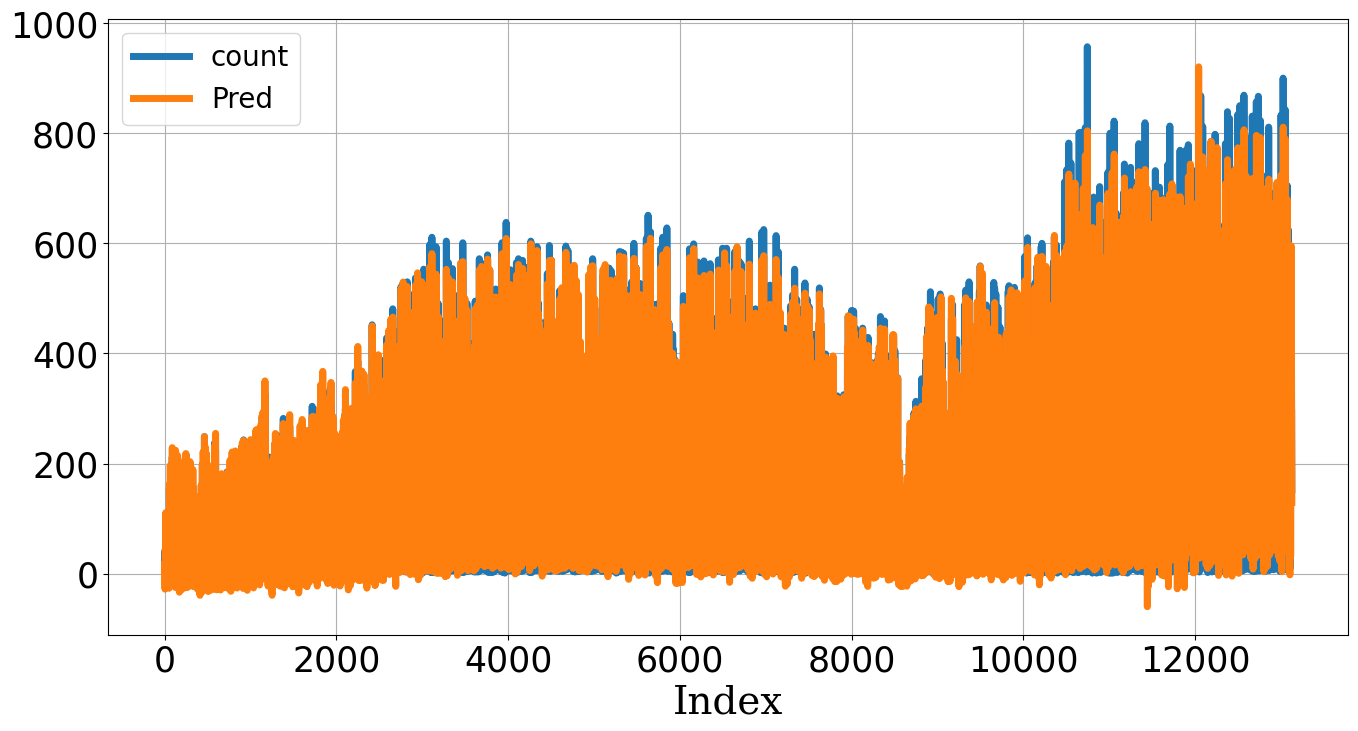

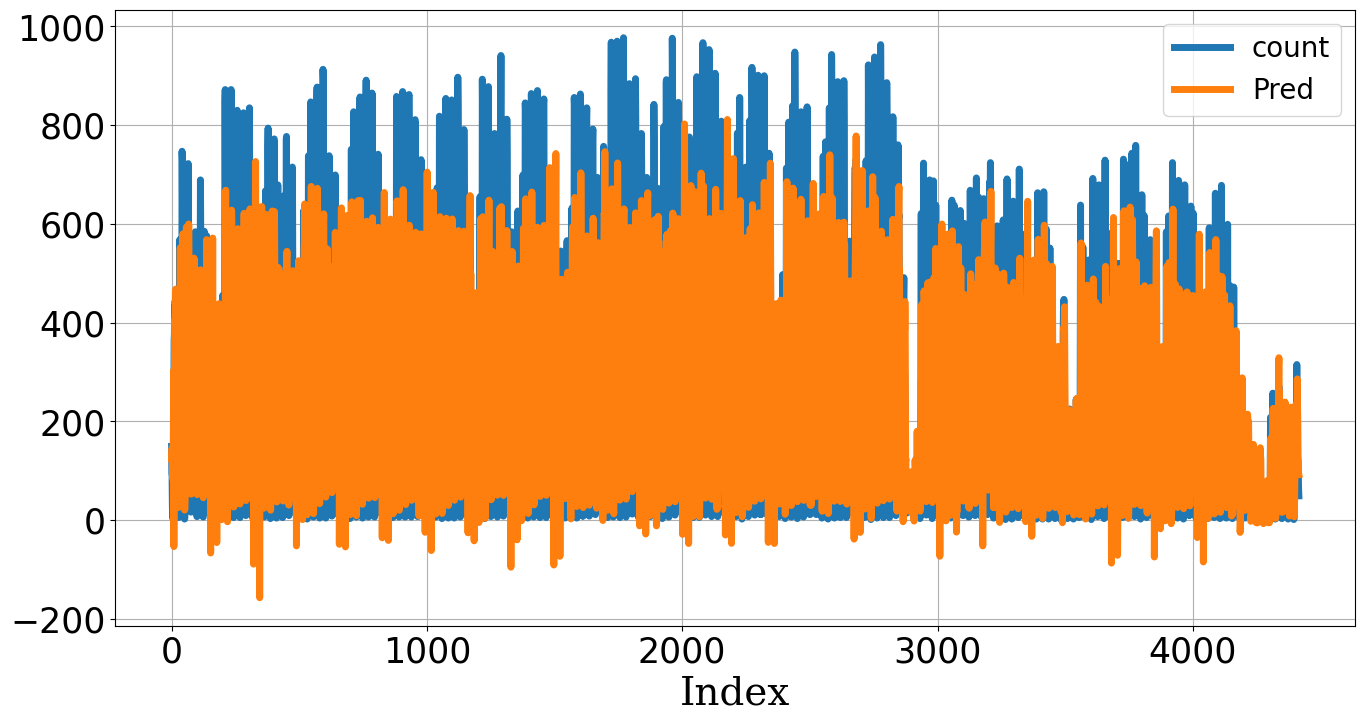

MAE       MSE  MAPE
Train  27.18  2,324.78  0.80
Test  113.06 25,908.84  1.29

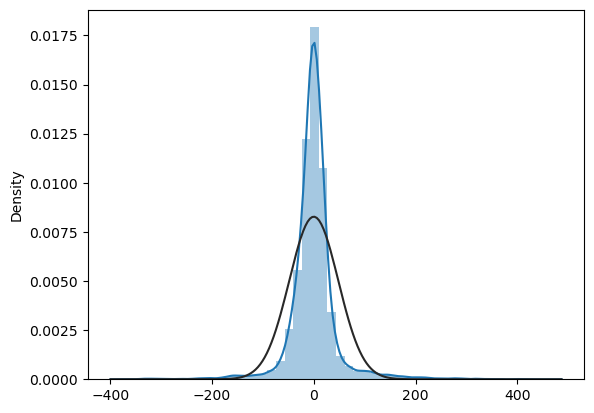

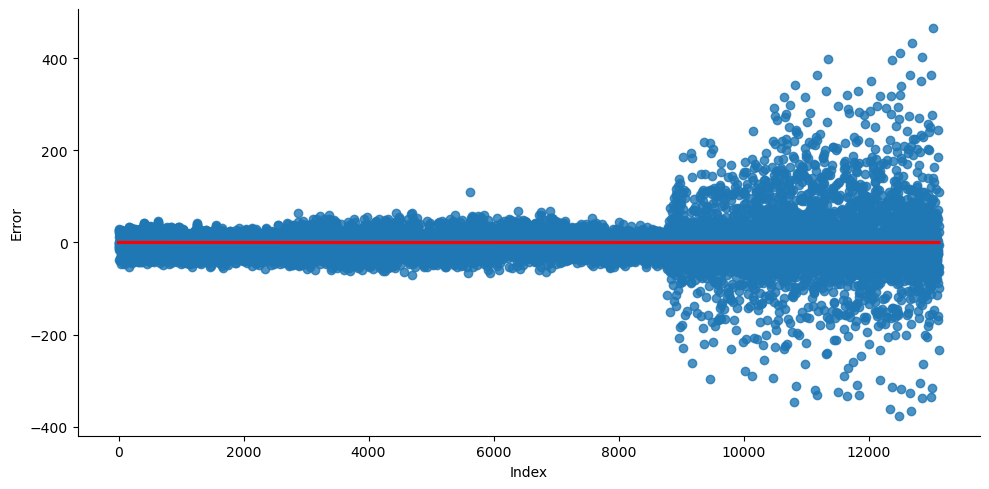

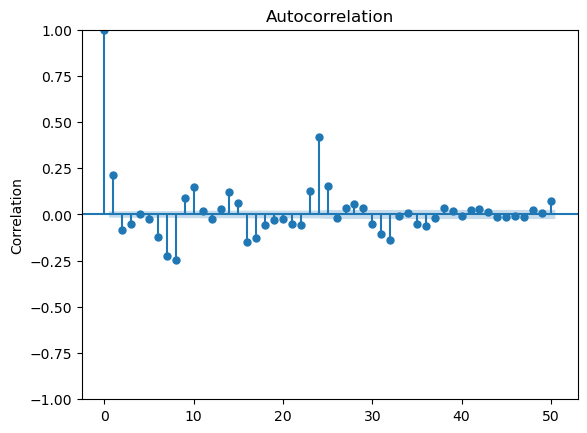

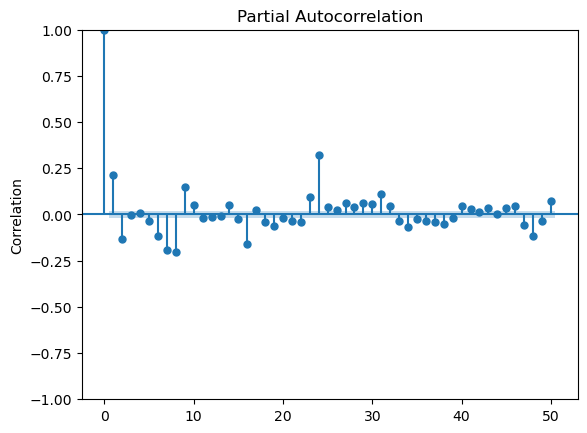

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.78             179.74         2,798.72   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics             7,261.76            -13.69               0.08  
p-value                         0.00              0.00               0.10  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             40.00             660.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

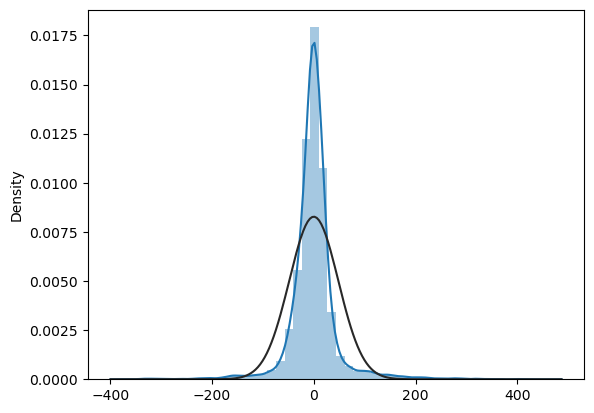

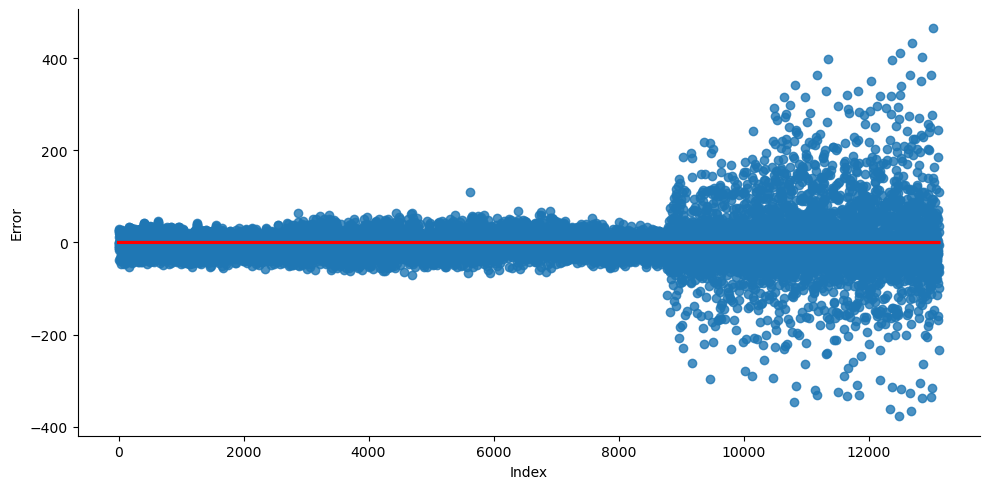

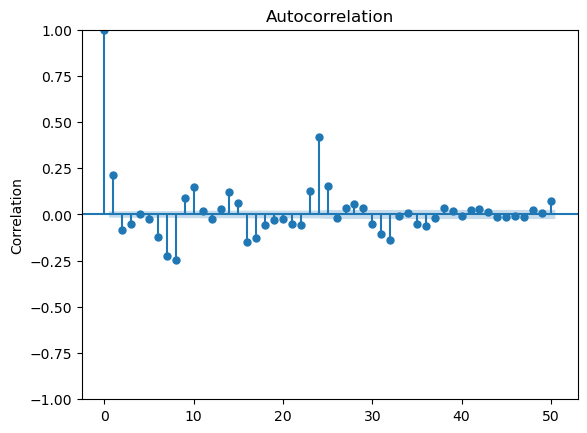

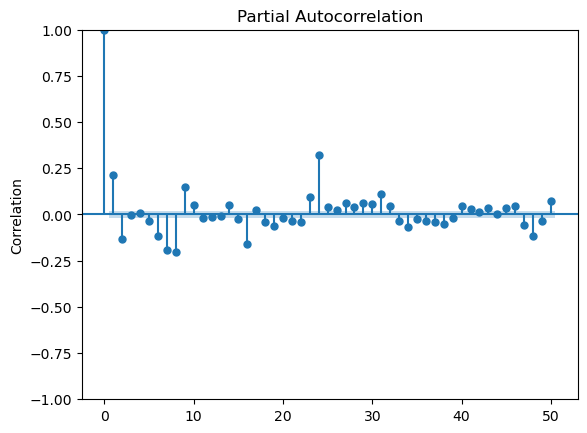

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.78             179.74         2,798.72   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics             7,261.76            -13.69               0.08  
p-value                         0.00              0.00               0.10  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             40.00             660.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

In [42]:
# 데이터 로딩
location = os.path.join('.', 'Data', 'BikeSharingDemand', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(), 
                                                    X_train_R, X_test_R)
###############

# Linear Regression
model_lr_RS = sm.OLS(Y_train, X_train_RS).fit()
display(model_lr_RS.summary())

Y_trpred_RS = pd.DataFrame(model_lr_RS.predict(X_train_RS), columns=['Pred'])
Y_tepred_RS = pd.DataFrame(model_lr_RS.predict(X_test_RS), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred_RS], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred_RS], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_RS = evaluation_reg_trte(Y_train, Y_trpred_RS, Y_test, Y_tepred_RS)
display(Score_RS)

# 에러 분석
Resid_tr = Y_train - Y_trpred_RS.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred_RS.values
Resid_te.columns = ['Error']

Error_tr_RS = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr_RS)
Error_te_RS = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_te_RS)

In [43]:
# 전처리 결과에 따른 성능 비교
display(Score_Raw)
display(Score_FEHalf)
display(Score_R)
display(Score_RS)

MAE       MSE  MAPE
Train 103.09 19,360.42  4.58
Test  150.03 43,410.27  3.17

MAE  MSE  MAPE
Train 0.01 0.04  0.00
Test  0.01 0.00  0.00

MAE       MSE  MAPE
Train  27.79  2,364.05  0.82
Test  113.99 26,316.17  1.34

MAE       MSE  MAPE
Train  27.18  2,324.78  0.80
Test  113.06 25,908.84  1.29

## 다중공선성 제거(Multicollinearity)

**0) 배경:** `예측 성능을 향상`시키려면 `독립변수들의 독립성이 높아야` 함  

> - **이상적:** Train 예측성능 $\uparrow$ + Test 예측성능 $\uparrow$  
> - **현실적:** Train 예측성능 <<< Test 예측성능 $\Longleftrightarrow$ `낮은 조건수(Condition Number)`

---

**1) 다중공선성(Multicollinearity)이 `발생`하는 경우:** 

> - 특정 독립변수가 `다른 독립변수의 조합으로 표현`될 수 있는 경우 
> - 독립변수들이 `서로 독립이 아니라 상호상관관계가 강한` 경우 
> - 독립변수의 공분산 행렬(Covariance Matrix) 벡터공간(Vector Space)의 `차원과 독립변수의 수가 달라` 변수들이 `모두 독립이 아닌 경우`(Full Rank가 아니다) 
>
> **=> "`다중공선성`이 있으면 독립변수 공분산 행렬의 `조건수(Condition Number) 증가`"**  
> **=> "조건수(Condition Number)가 증가하면 `과적합(Overfitting) 발생가능성 증가`"**  

---

**2) 다중공선성을 줄이는 방법:**

**(1) Variance Inflation Factor(VIF) 변수선택**

> **"VIF는 `독립변수를 다른 독립변수들로 선형회귀한 성능들을 비교`하여 상호 `의존성이 높은 변수를 제거`하거나 `의존성이 낮은 변수를 선택`"**
>
> $$
\begin{aligned}
VIF_i &= Var(\hat{\beta}_i) = \dfrac{\sigma^2_{\epsilon}}{(n-1)Var(X_i)} \cdot \dfrac{1}{1-R_i^2} \\
& (R_i^2:\text{ 독립변수 } X_i를 \text{ 다른 독립변수들로 선형회귀한 성능})
\end{aligned}
$$

**(2) Principal Component Analysis(PCA) 변수선택**

> **"PCA는 `다차원인 독립변수를 서로 독립인 소차원으로 변경`하는 알고리즘으로, 이를 통해 상호 의존성을 제거"**

<center><img src='Image/Advanced/PCA_2D_Ex.png' width='900'>(https://www.mdpi.com/2076-3417/11/9/3780)</center>
<center><img src='Image/Advanced/PCA_Visualization.png' width='900'></center>


In [44]:
# X_train 데이터의 기초통계 확인해보기
X_train_RS.describe()

season   holiday  workingday   weather      temp     atemp  humidity  \
count 13,128.00 13,128.00   13,128.00 13,128.00 13,128.00 13,128.00 13,128.00   
mean       0.00      0.00        0.00      0.00      0.01      0.01      0.03   
std        0.00      0.00        0.00      0.00      0.00      0.00      0.01   
min        0.00      0.00        0.00      0.00      0.00      0.00      0.00   
25%        0.00      0.00        0.00      0.00      0.01      0.01      0.02   
50%        0.00      0.00        0.00      0.00      0.01      0.01      0.03   
75%        0.00      0.00        0.00      0.00      0.01      0.01      0.04   
max        0.00      0.00        0.00      0.00      0.02      0.02      0.05   

       windspeed  count_trend  count_seasonal  ...  Quater_ver2     Month  \
count  13,128.00    13,128.00       13,128.00  ...    13,128.00 13,128.00   
mean        0.01         0.07           -0.00  ...         0.00      0.00   
std         0.00         0.03            0.06  ...         0.00      0.00   
min         0.00         0.01           -0.09  ...         0.00      0.00   
25%         0.00         0.04           -0.06  ...         0.00      0.00   
50%         0.01         0.07            0.01  ...         0.00      0.00   
75%         0.01         0.09            0.03  ...         0.00      0.00   
max         0.03         0.13            0.13  ...         0.00      0.01   

            Day      Hour  DayofWeek  count_lag1  count_lag2  Quater_Dummy_2  \
count 13,128.00 13,128.00  13,128.00   13,128.00   13,128.00       13,128.00   
mean       0.01      0.01       0.00        0.08        0.08            0.00   
std        0.00      0.00       0.00        0.07        0.07            0.00   
min        0.00      0.00       0.00        0.00        0.00            0.00   
25%        0.00      0.00       0.00        0.02        0.02            0.00   
50%        0.01      0.01       0.00        0.06        0.06            0.00   
75%        0.01      0.01       0.00        0.12        0.12            0.00   
max        0.02      0.01       0.00        0.41        0.40            0.00   

       Quater_Dummy_3  Quater_Dummy_4  
count       13,128.00       13,128.00  
mean             0.00            0.00  
std              0.00            0.00  
min              0.00            0.00  
25%              0.00            0.00  
50%              0.00            0.00  
75%              0.00            0.00  
max              0.00            0.00  

[8 rows x 24 columns]

In [45]:
# X_train 데이터의 상관관계로 다중공선성 가능성 확인
X_train_RS.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

In [46]:
# VIF 함수로 독립변수들 사이의 의존도 확인
# 첫번째 독립변수를 다른 독립변수들도 선형회귀분석을 했을 때의 의존도 정도 출력
variance_inflation_factor(X_train_RS, 1)

1.608158288604109

In [47]:
# 모든 독립변수들의 VIF 수치 확인
[variance_inflation_factor(X_train_RS.values, i) for i in range(X_train_RS.shape[1])]

[29.52178292513622,
 1.608158288604109,
 9.032334567070578,
 8.384320017097181,
 593.7877053042151,
 606.9180548206751,
 19.026150509488744,
 4.509334537300073,
 67.13325046723378,
 2.8919778697688616,
 68.35031997154296,
 77.14125287346324,
 1.5625018078359032,
 77.55708139347128,
 6.687982730978987,
 73.28967927992582,
 4.317291118419956,
 6.868651578377079,
 9.026239795597293,
 11.13664730769367,
 9.64410327497406,
 8.828873254820616,
 12.826040137348802,
 28.552319468357123]

In [48]:
# 모든 독립변수들의 VIF 수치 확인 및 오름차순 정렬
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_RS.values, i) 
                     for i in range(X_train_RS.shape[1])]
vif['Feature'] = X_train_RS.columns
vif.sort_values(by='VIF_Factor', ascending=True)

VIF_Factor         Feature
12        1.56      count_diff
1         1.61         holiday
9         2.89  count_seasonal
16        4.32             Day
7         4.51       windspeed
..         ...             ...
15       73.29           Month
11       77.14      count_Week
13       77.56            Year
4       593.79            temp
5       606.92           atemp

[24 rows x 2 columns]

In [49]:
# 모든 독립변수들의 VIF 수치 확인 및 오름차순 정렬 후 상위 10개 독립변수만 추출
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_RS.values, i) 
                     for i in range(X_train_RS.shape[1])]
vif['Feature'] = X_train_RS.columns
vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:10].values

array(['count_diff', 'holiday', 'count_seasonal', 'Day', 'windspeed',
       'Quater_ver2', 'Hour', 'weather', 'Quater_Dummy_2', 'DayofWeek'],
      dtype=object)

### Code Summary

In [50]:
# 모든 독립변수들의 VIF 수치 확인 및 오름차순 정렬 후 상위 num_variables개 독립변수만 추출
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    
    return X_colname_vif

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.30it/s]


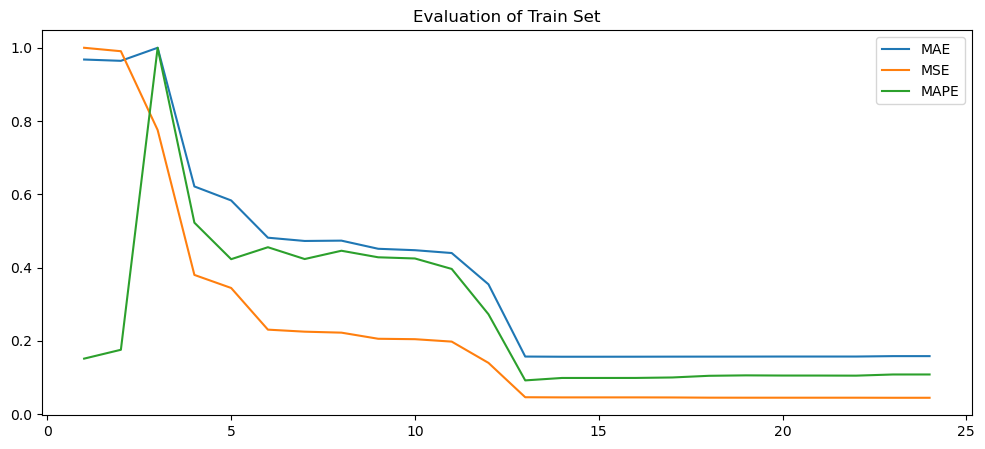

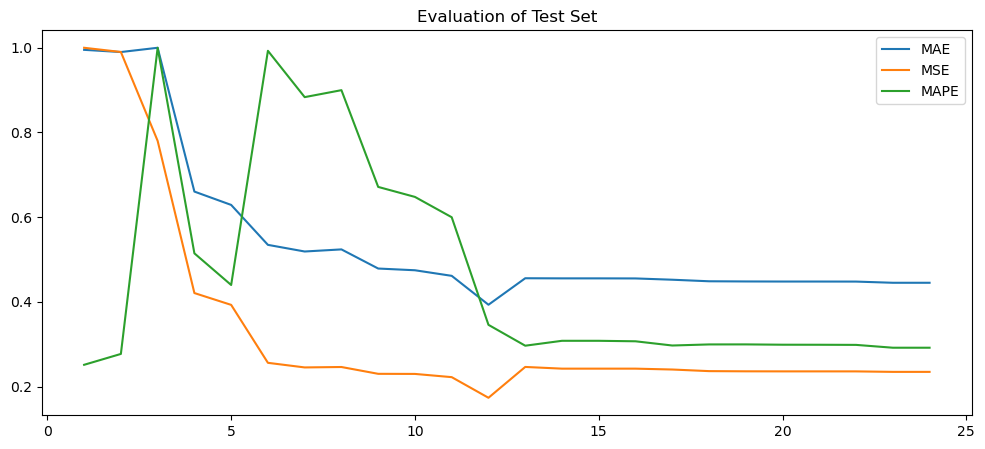

In [51]:
# 데이터 로딩
location = os.path.join('.', 'Data', 'BikeSharingDemand', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(), 
                                                    X_train_R, X_test_R)
###############

# VIF로 독립변수 추출 갯수 증가에 따른 성능변화 확인
eval_tr = pd.DataFrame()
eval_te = pd.DataFrame()
for i in tqdm(range(1,len(X_train_RS.columns)+1)):
    X_colname_vif = feature_engineering_XbyVIF(X_train_RS, i)
    X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
    
    # Applying Base Model
    model_lr_RSM = sm.OLS(Y_train, X_train_RSM).fit()
    Y_trpred_RSM = model_lr_RSM.predict(X_train_RSM).values
    Y_tepred_RSM = model_lr_RSM.predict(X_test_RSM).values

    # Evaluation
    Score_RSM = evaluation_reg_trte(Y_train, Y_trpred_RSM, Y_test, Y_tepred_RSM)
    eval_tr = pd.concat([eval_tr, Score_RSM.loc[['Train']]], axis=0)
    eval_te = pd.concat([eval_te, Score_RSM.loc[['Test']]], axis=0)
eval_tr.index = range(1,len(X_train_RS.columns)+1)
eval_te.index = range(1,len(X_train_RS.columns)+1)

plt.figure(figsize=(12,5))
plt.plot(eval_tr/eval_tr.max())
plt.legend(eval_tr.columns)
plt.title('Evaluation of Train Set')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(eval_te/eval_te.max())
plt.legend(eval_te.columns)
plt.title('Evaluation of Test Set')
plt.show()

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              6925.
Date:                Sun, 15 Jan 2023   Prob (F-statistic):                        0.00
Time:                        17:41:36   Log-Likelihood:                         -77008.
No. Observations:               13128   AIC:                                  1.540e+05
Df Residuals:                   13116   BIC:                                  1.541e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_diff      1289.2806     25.881     49.816      0.000    1238.550    1340.011
holiday         7.141e+04   1.01e+04      7.044      0.000    5.15e+04    9.13e+04
count_seasonal  1270.9307     16.107     78.906      0.000    1239.359    1302.503
Day             1151.2606    168.230      6.843      0.000     821.505    1481.017
windspeed       -234.1084    180.733     -1.295      0.195    -588.370     120.154
Quater_ver2     2.865e+04    930.475     30.787      0.000    2.68e+04    3.05e+04
Hour           -3514.0425    282.316    -12.447      0.000   -4067.422   -2960.663
weather        -2.423e+04   2238.550    -10.825      0.000   -2.86e+04   -1.98e+04
Quater_Dummy_2  6.725e+04   3436.993     19.566      0.000    6.05e+04     7.4e+04
DayofWeek       1.621e+04    912.387     17.768      0.000    1.44e+04     1.8e+04
workingday      7.695e+04   4056.717     18.970      0.000     6.9e+04    8.49e+04
count_lag2      1061.0008     14.379     73.788      0.000    1032.816    1089.186
==============================================================================
Omnibus:                     1665.324   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5853.426
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

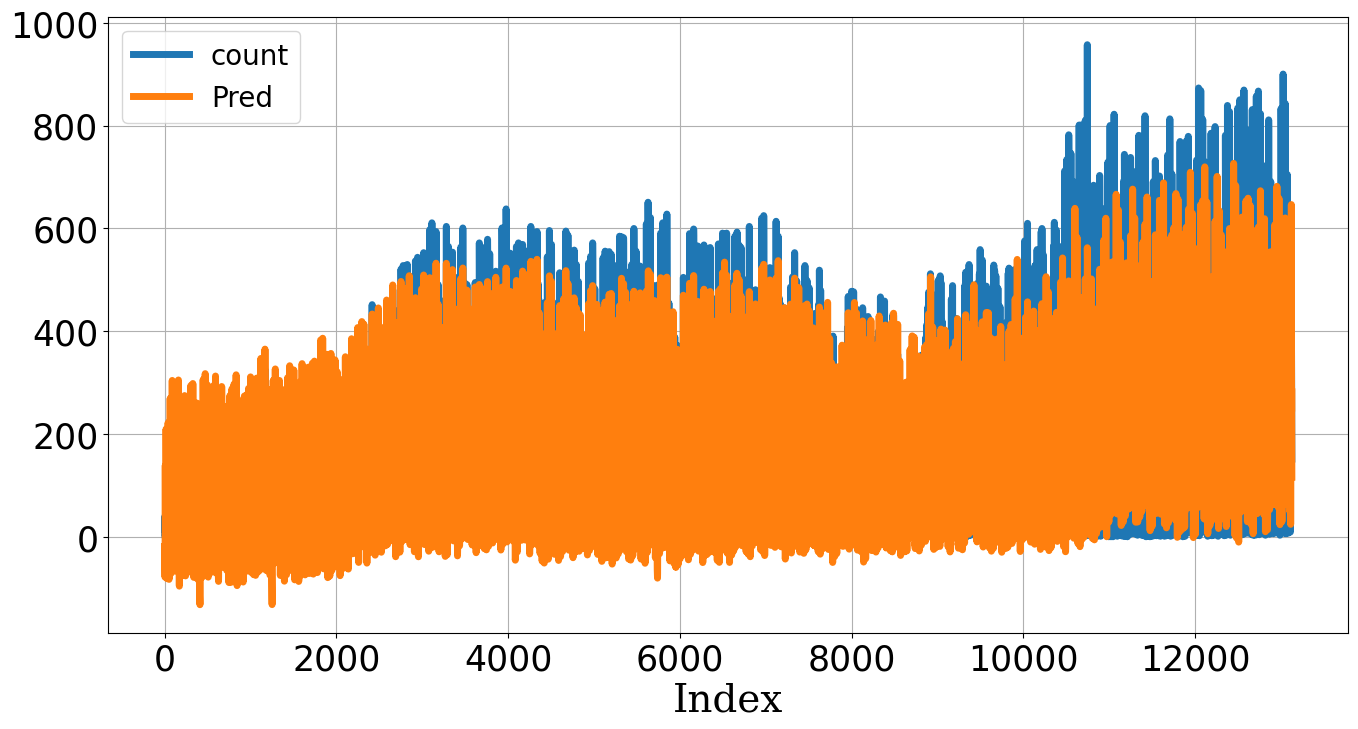

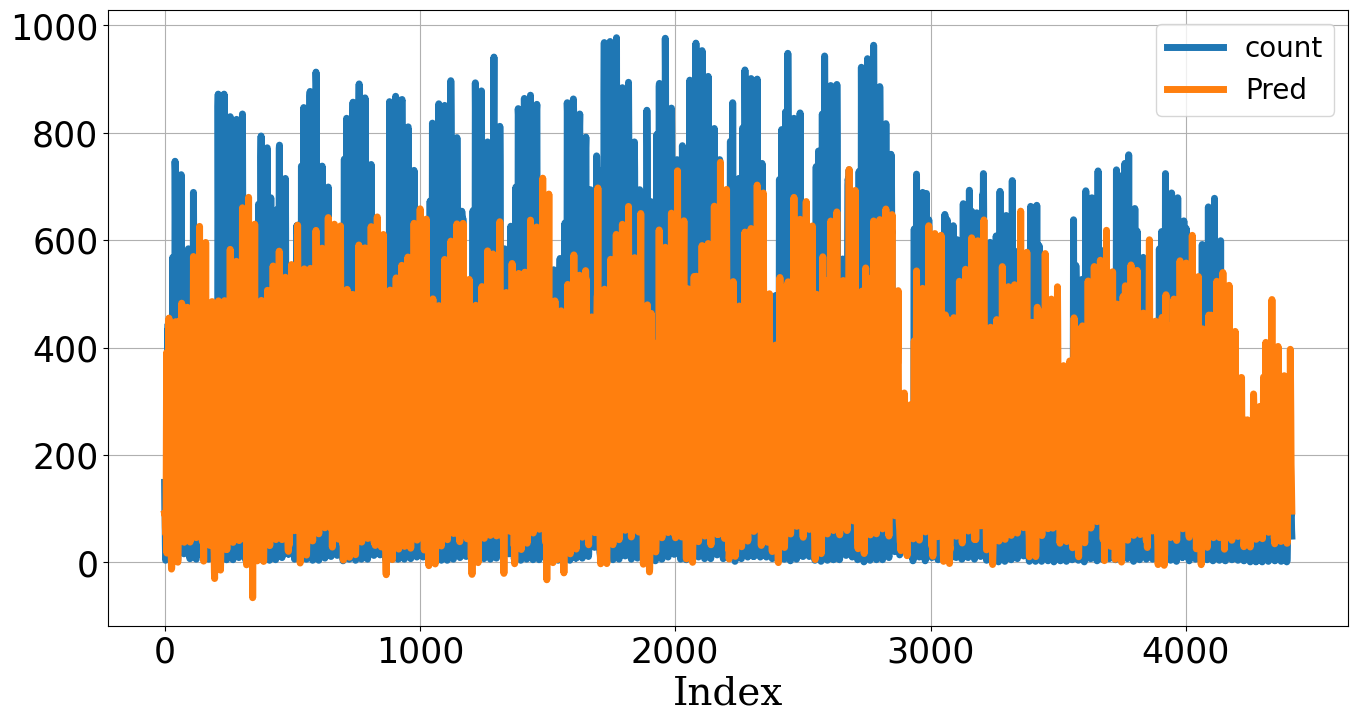

MAE       MSE  MAPE
Train 60.84  7,288.40  2.02
Test  99.87 19,151.40  1.53

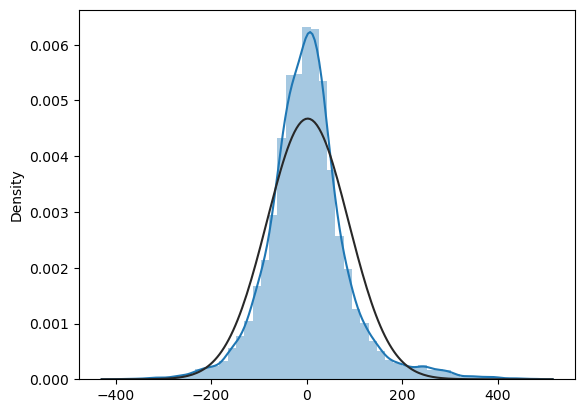

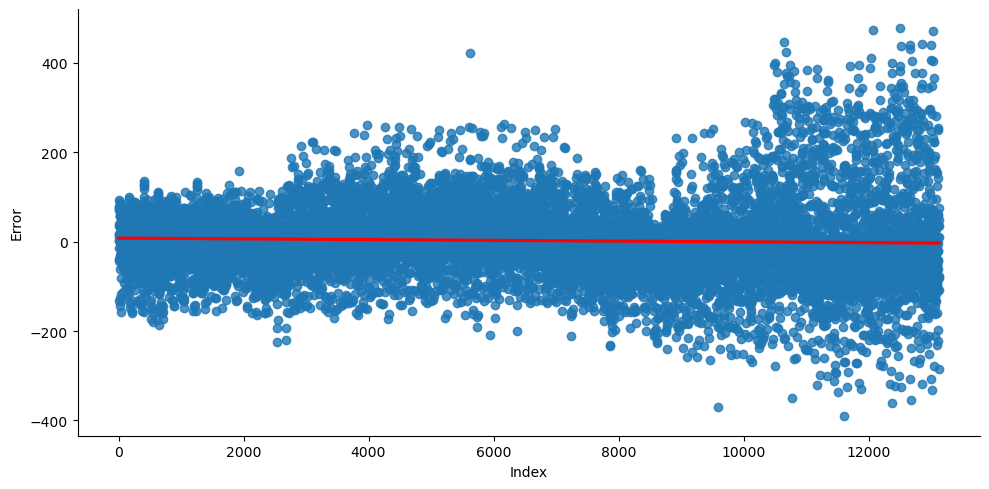

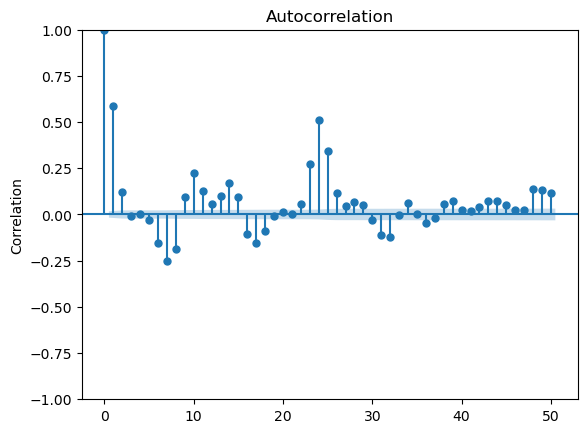

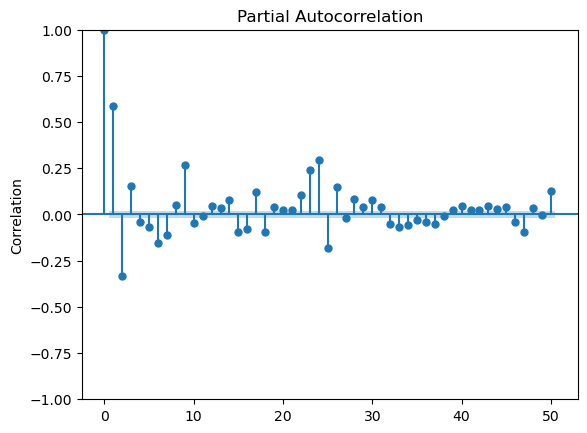

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.95             172.83         7,076.59   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics            16,328.78            -10.30               1.32  
p-value                         0.00              0.00               0.01  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             41.00              89.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

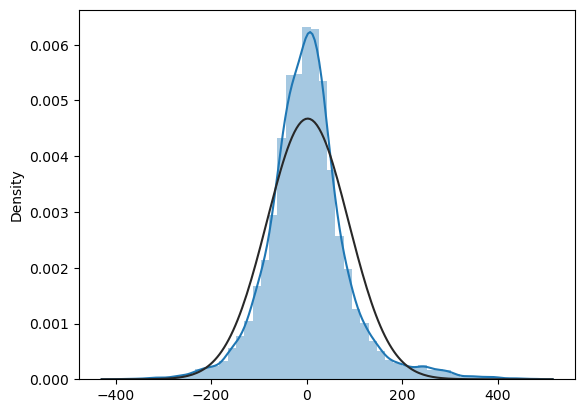

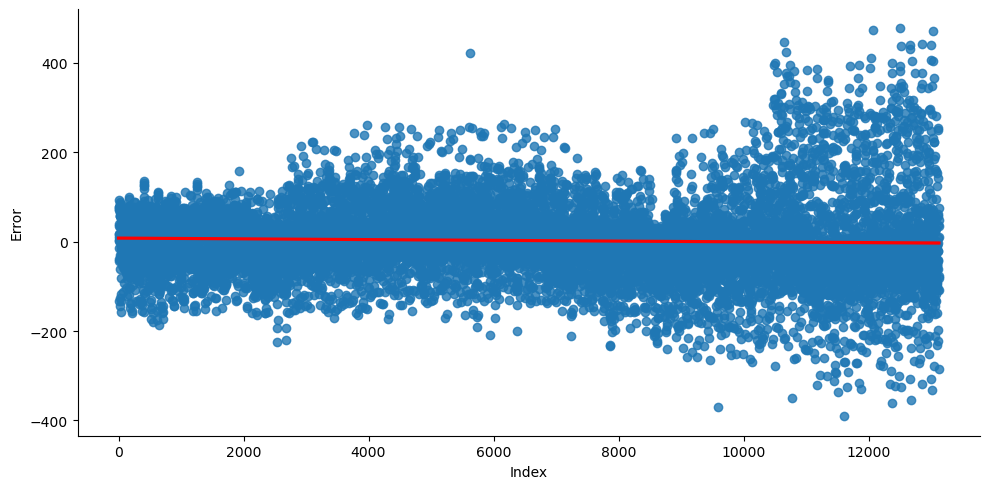

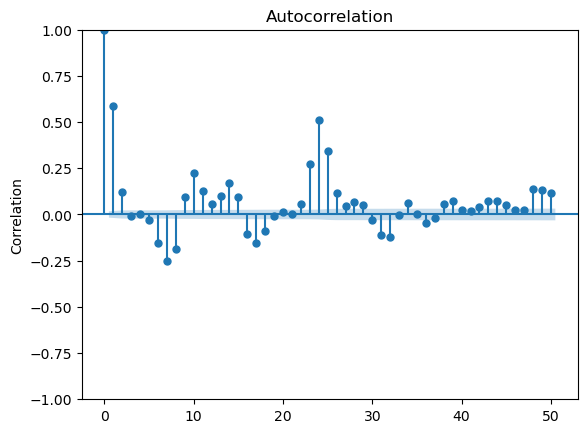

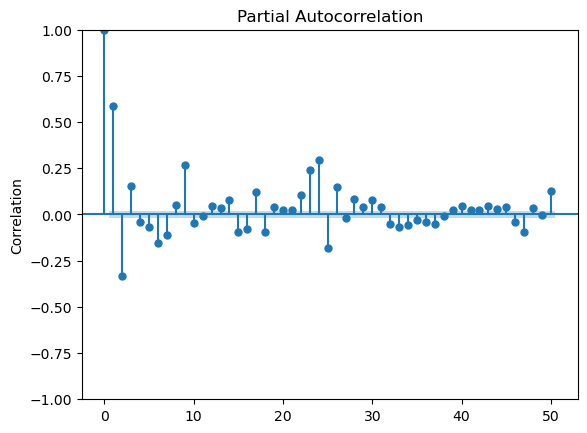

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.95             172.83         7,076.59   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics            16,328.78            -10.30               1.32  
p-value                         0.00              0.00               0.01  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             41.00              89.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

In [52]:
# 데이터 로딩
location = os.path.join('.', 'Data', 'BikeSharingDemand', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(), 
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# Linear Regression
model_lr_RSM = sm.OLS(Y_train, X_train_RSM).fit()
display(model_lr_RSM.summary())

Y_trpred_RSM = pd.DataFrame(model_lr_RSM.predict(X_train_RSM), columns=['Pred'])
Y_tepred_RSM = pd.DataFrame(model_lr_RSM.predict(X_test_RSM), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred_RSM], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred_RSM], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_RSM = evaluation_reg_trte(Y_train, Y_trpred_RSM, Y_test, Y_tepred_RSM)
display(Score_RSM)

# 에러 분석
Resid_tr = Y_train - Y_trpred_RSM.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred_RSM.values
Resid_te.columns = ['Error']

Error_tr_RSM = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr_RSM)
Error_te_RSM = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_te_RSM)

# **Comparison:** 전처리 단계별 결과비교

In [53]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 30

In [54]:
# 전처리 결과에 따른 성능 비교
display(Score_Raw)
display(Score_FEHalf)
display(Score_R)
display(Score_RS)
display(Score_RSM)

MAE       MSE  MAPE
Train 103.09 19,360.42  4.58
Test  150.03 43,410.27  3.17

MAE  MSE  MAPE
Train 0.01 0.04  0.00
Test  0.01 0.00  0.00

MAE       MSE  MAPE
Train  27.79  2,364.05  0.82
Test  113.99 26,316.17  1.34

MAE       MSE  MAPE
Train  27.18  2,324.78  0.80
Test  113.06 25,908.84  1.29

MAE       MSE  MAPE
Train 60.84  7,288.40  2.02
Test  99.87 19,151.40  1.53

In [55]:
# 전처리 결과에 따른 적합력 비교
comparison_r2 = pd.DataFrame([model_lr_Raw.rsquared_adj, model_lr_R.rsquared_adj, 
                              model_lr_RS.rsquared_adj, model_lr_RSM.rsquared_adj], 
                             index=['rd', 'feR', 'feRS', 'feRSM'], columns=['R^2_adj']).T
comparison_fvalue = pd.DataFrame([model_lr_Raw.fvalue, model_lr_R.fvalue, 
                                  model_lr_RS.fvalue, model_lr_RSM.fvalue], 
                                 index=['rd', 'feR', 'feRS', 'feRSM'], columns=['F-statistics']).T
comparison_fpvalue = pd.DataFrame([model_lr_Raw.f_pvalue, model_lr_R.f_pvalue, 
                                   model_lr_RS.f_pvalue, model_lr_RSM.f_pvalue], 
                                  index=['rd', 'feR', 'feRS', 'feRSM'], columns=['prob(F-stat.)']).T
comparison_aic = pd.DataFrame([model_lr_Raw.aic, model_lr_R.aic, 
                              model_lr_RS.aic, model_lr_RSM.aic], 
                             index=['rd', 'feR', 'feRS', 'feRSM'], columns=['aic']).T
comparison_bic = pd.DataFrame([model_lr_Raw.bic, model_lr_R.bic, 
                               model_lr_RS.bic, model_lr_RSM.bic], 
                              index=['rd', 'feR', 'feRS', 'feRSM'], columns=['bic']).T
pd.concat([comparison_r2, comparison_fvalue, comparison_fpvalue, comparison_aic, comparison_bic], axis=0)

rd        feR       feRS      feRSM
R^2_adj             0.64       0.91       0.96       0.86
F-statistics    2,889.02   5,657.99  12,011.02   6,924.95
prob(F-stat.)       0.00       0.00       0.00       0.00
aic           166,857.95 139,283.69 139,063.76 154,040.60
bic           166,917.81 139,463.27 139,243.34 154,130.39

In [56]:
# comparison of coefficients
comparison_fit_rd = pd.concat([pd.DataFrame(model_lr_Raw.params, columns=['coef']), 
                               pd.DataFrame(model_lr_Raw.pvalues, columns=['prob(coef)'])], axis=1)
comparison_fit_feR = pd.concat([pd.DataFrame(model_lr_R.params, columns=['coef']), 
                               pd.DataFrame(model_lr_R.pvalues, columns=['prob(coef)'])], axis=1)
comparison_fit_feRS = pd.concat([pd.DataFrame(model_lr_RS.params, columns=['coef']), 
                               pd.DataFrame(model_lr_RS.pvalues, columns=['prob(coef)'])], axis=1)
comparison_fit_feRSM = pd.concat([pd.DataFrame(model_lr_RSM.params, columns=['coef']), 
                               pd.DataFrame(model_lr_RSM.pvalues, columns=['prob(coef)'])], axis=1)
pd.concat([comparison_fit_rd, comparison_fit_feR, comparison_fit_feRS, comparison_fit_feRSM], axis=1)

coef  prob(coef)   coef  prob(coef)       coef  prob(coef)  \
season          3.37        0.01   2.75        0.00   4,315.62        0.03   
holiday        -6.29        0.40   0.62        0.85    -409.21        0.95   
workingday     10.36        0.00   2.20        0.15   2,915.86        0.35   
weather         7.19        0.00  -5.88        0.00 -11,054.49        0.00   
temp           -7.85        0.00   0.56        0.25   1,593.80        0.11   
atemp          16.07        0.00   0.40        0.34     112.30        0.90   
humidity       -1.74        0.00  -0.07        0.01    -112.49        0.05   
windspeed       2.27        0.00  -0.12        0.03    -242.00        0.04   
count_trend      NaN         NaN   0.07        0.00     119.38        0.01   
count_seasonal   NaN         NaN   0.19        0.00     356.49        0.00   
count_Day        NaN         NaN   0.10        0.00     203.83        0.00   
count_Week       NaN         NaN  -0.08        0.00    -114.35        0.03   
count_diff       NaN         NaN   0.71        0.00   1,524.59        0.00   
Year             NaN         NaN   0.00        0.85      -2.37        0.53   
Quater_ver2      NaN         NaN   5.68        0.00  11,184.46        0.00   
Month            NaN         NaN   1.10        0.05   2,308.47        0.05   
Day              NaN         NaN  -0.03        0.50     -42.30        0.67   
Hour             NaN         NaN   0.12        0.16     -88.00        0.60   
DayofWeek        NaN         NaN   0.36        0.31     298.03        0.68   
count_lag1       NaN         NaN   0.93        0.00   2,036.38        0.00   
count_lag2       NaN         NaN  -0.19        0.00    -384.26        0.00   
Quater_Dummy_2   NaN         NaN  -7.27        0.00 -13,165.52        0.00   
Quater_Dummy_3   NaN         NaN -21.52        0.00 -43,207.92        0.00   
Quater_Dummy_4   NaN         NaN -26.75        0.00 -54,152.60        0.00   

                     coef  prob(coef)  
season                NaN         NaN  
holiday         71,406.59        0.00  
workingday      76,954.13        0.00  
weather        -24,231.78        0.00  
temp                  NaN         NaN  
atemp                 NaN         NaN  
humidity              NaN         NaN  
windspeed         -234.11        0.20  
count_trend           NaN         NaN  
count_seasonal   1,270.93        0.00  
count_Day             NaN         NaN  
count_Week            NaN         NaN  
count_diff       1,289.28        0.00  
Year                  NaN         NaN  
Quater_ver2     28,646.27        0.00  
Month                 NaN         NaN  
Day              1,151.26        0.00  
Hour            -3,514.04        0.00  
DayofWeek       16,211.12        0.00  
count_lag1            NaN         NaN  
count_lag2       1,061.00        0.00  
Quater_Dummy_2  67,249.49        0.00  
Quater_Dummy_3        NaN         NaN  
Quater_Dummy_4        NaN         NaN

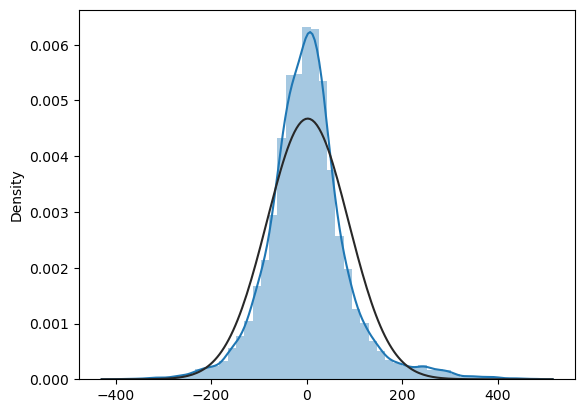

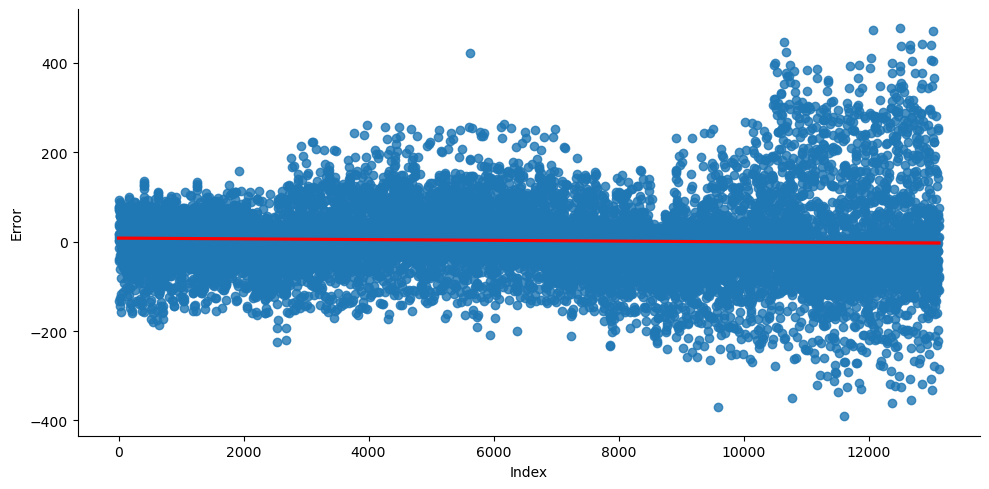

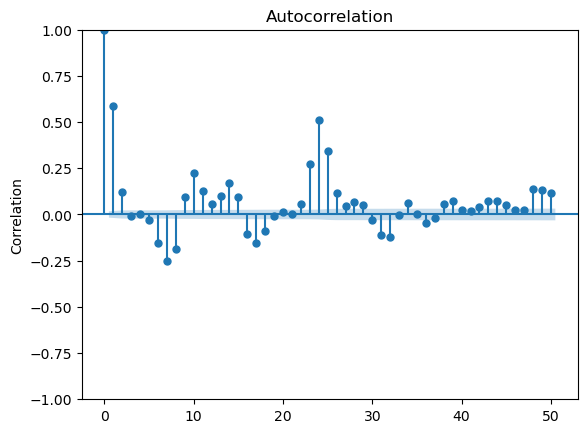

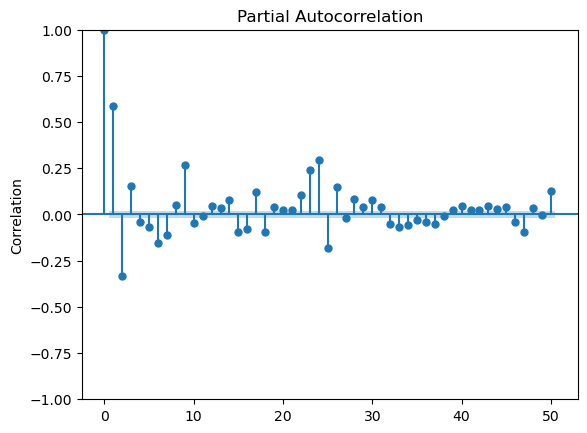

C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\KK\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Normality Heteroscedasticity  Autocorr(lag10)  \
Test Statistics           0.95             172.83         7,076.59   
p-value                   0.00               0.00             0.00   
Alternative                NaN          two-sided              NaN   
Used Lag                   NaN                NaN              NaN   
Critical Value(1%)         NaN                NaN              NaN   
Critical Value(5%)         NaN                NaN              NaN   
Critical Value(10%)        NaN                NaN              NaN   

                     Autocorr(lag50)  Stationarity_ADF  Stationarity_KPSS  
Test Statistics            16,328.78            -10.30               1.32  
p-value                         0.00              0.00               0.01  
Alternative                      NaN               NaN                NaN  
Used Lag                         NaN             41.00              89.00  
Critical Value(1%)               NaN             -3.43               0.74  
Critical Value(5%)               NaN             -2.86               0.46  
Critical Value(10%)              NaN             -2.57               0.35

In [57]:
# 언제까지 어떻게 해야 합니까?
# 1) 모든 성능평가 및 검증지표들이 높고 계수(가중치)도 현실적일 때까지
# 2) 지금까지는 독립변수만 전처리를 했는데 종속변수도 전처리하면 어떨까?
error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)